# <font color='056938'>**Caso de estudio**
La agencia de marketing Sterling Cooper Advertising tiene en su planta de empleados alrededor de
4.000 personas directamente contratadas. Sin embargo, el departamento de recursos humanos ha
reportado cifras preocupantes a la dirección de la agencia, indicando que cada año, alrededor del
15% de sus empleados abandonan la empresa y necesitan ser reemplazados, en la mayoría de
casos, con muy poco tiempo para el proceso de selección y contratación. La dirección cree que este
nivel de bajas (empleados que se marchan, ya sea por decisión propia o porque son despedidos) es
perjudicial para la empresa, por las siguientes razones:

* Los proyectos de los antiguos empleados se retrasan, lo que dificulta el cumplimiento de los
plazos, con la consiguiente pérdida de reputación entre sus clientes y socios.

* El departamento de recursos humanos requiere mucha inversión por los niveles de rotación,
así que la mayoría de su personal está dedicado a tareas de reclutamiento de nuevo talento,
haciendo más lento el proceso de desarrollo de otras áreas dentro del departamento
dedicadas por ejemplo a la formación o bienestar de sus empleados.

* En la mayoría de los casos, hay que formar a los nuevos empleados para el puesto y/o
darles tiempo para que se adapten a la cultura de la agencia.

Por esta razón, la dirección ha contratado a su equipo de consultores con el objetivo de predecir
oportunamente qué empleados podrían abandonar la organización, de manera que sea posible
implementar acciones preventivas orientadas a retener a la mayoría de quienes estén en riesgo.
Asimismo, desean identificar los factores que más influyen en la decisión de renunciar, con el fin de
diseñar estrategias sostenibles a largo plazo que fortalezcan la permanencia del talento dentro de la
empresa.

**Grupo 3:**
* Ximena Castañeda Ruiz
* Sara Sandoval Alvarez
* Catalina Betancur Higuita
* Juan Manuel Arredondo

## **Librerías necesarias**

In [27]:
!pip install plot-metric

In [28]:
!pip install -U imbalanced-learn

In [29]:
import pandas as pd
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import display, Markdown
pd.set_option('display.max_columns', None)
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
from matplotlib.pyplot import figure
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.datasets import make_classification
from collections import Counter

## **Datos**

* ***gen_dat:*** Información general del empleado

* ***em_sur_dat:*** resultados de encuesta realizada a los empleados respecto a su nivel de satisfacción con su empleo actual

* ***manag_surv:*** resultados obtenidos por los empleados en su última evaluación dedesempeño.

* ***time_work:*** contiene el tiempo promedio de dedicación del empleado al día.

In [30]:
em_sur_dat = pd.read_csv("https://raw.githubusercontent.com/juanmarredondo99-eng/UdeA_caso_estudio_abandono_laboral/refs/heads/main/data/raw/employee_survey_data.csv")
gen_dat = pd.read_csv("https://raw.githubusercontent.com/juanmarredondo99-eng/UdeA_caso_estudio_abandono_laboral/refs/heads/main/data/raw/general_data.csv")
manag_surv = pd.read_csv("https://raw.githubusercontent.com/juanmarredondo99-eng/UdeA_caso_estudio_abandono_laboral/refs/heads/main/data/raw/manager_survey_data.csv")
time_work = pd.read_csv("https://raw.githubusercontent.com/juanmarredondo99-eng/UdeA_caso_estudio_abandono_laboral/refs/heads/main/data/raw/time_work.csv", sep=";")

## **Visualización previa de bases de datos**

In [31]:
gen_dat.head(2)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,1,Healthcare Representative,Married,131160,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,1,Research Scientist,Single,41890,0.0,Y,23,8,1,6.0,3,5,1,4


In [32]:
em_sur_dat.head(2)

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.0,4.0,2.0
1,2,3.0,2.0,4.0


In [33]:
manag_surv.head(2)

,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4


In [34]:
time_work.head(2)

,EmployeeID,mean_time
0,1,"6,8702"
1,2,"7,316"


# <font color='PURPLE'> **a. Limpieza y transformación de los datos**

## <font color='orange'> **Integración de las bases de datos**


Dado el problema de rotación de personal en la agencia Sterling Cooper Advertising,
es necesario contar con toda la información disponible de cada empleado para poder
detectar patrones de abandono.

Para esto, se integraron los cuatro conjuntos de datos proporcionados:



In [35]:
dfmarketing = (gen_dat
      .merge(em_sur_dat, on="EmployeeID", how="left")
      .merge(manag_surv, on="EmployeeID", how="left")
      .merge(time_work, on="EmployeeID", how="left"))

In [36]:
dfmarketing.shape

(4410, 30)

In [37]:
dfmarketing.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,mean_time
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,1,Healthcare Representative,Married,131160,1.0,Y,11,8,0,1.0,6,1,0,0,3.0,4.0,2.0,3,3,"6,8702"
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,1,Research Scientist,Single,41890,0.0,Y,23,8,1,6.0,3,5,1,4,3.0,2.0,4.0,2,4,"7,316"
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,4,Sales Executive,Married,193280,1.0,Y,15,8,3,5.0,2,5,0,3,2.0,2.0,1.0,3,3,"6,8161"
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,3,Human Resources,Married,83210,3.0,Y,11,8,3,13.0,5,8,7,5,4.0,4.0,3.0,2,3,"6,7892"
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,1,Sales Executive,Single,23420,4.0,Y,12,8,2,9.0,2,6,0,4,4.0,1.0,3.0,3,3,"7,8776"


## <font color='orange'> **Transformación de `mean_time`**

Se observa que la variable `mean_time` esta en formato texto con comas en lugar de puntos decimales (ejemplo: `6,8702`), lo cual impide su uso como variable numérica.

Para solucionarlo, se reemplazaron las comas por puntos y se transformó el campo a tipo `float`.
De esta forma, `mean_time` queda listo para el análisis estadístico y la construcción del modelo de predicción de *Attrition*.


In [38]:
dfmarketing["mean_time"] = (dfmarketing["mean_time"].astype(str).str.replace(",", ".").astype(float))
dfmarketing.info()
dfmarketing.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,mean_time
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,1,Healthcare Representative,Married,131160,1.0,Y,11,8,0,1.0,6,1,0,0,3.0,4.0,2.0,3,3,6.8702
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,1,Research Scientist,Single,41890,0.0,Y,23,8,1,6.0,3,5,1,4,3.0,2.0,4.0,2,4,7.3160
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,4,Sales Executive,Married,193280,1.0,Y,15,8,3,5.0,2,5,0,3,2.0,2.0,1.0,3,3,6.8161
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,3,Human Resources,Married,83210,3.0,Y,11,8,3,13.0,5,8,7,5,4.0,4.0,3.0,2,3,6.7892
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,1,Sales Executive,Single,23420,4.0,Y,12,8,2,9.0,2,6,0,4,4.0,1.0,3.0,3,3,7.8776


## <font color='orange'>**Datos duplicados**

En esta etapa del preprocesamiento, se busca identificar registros duplicados dentro de las bases de datos. La presencia de duplicados puede afectar la calidad del análisis, generando sesgos en los resultados o inflando la representatividad de ciertos casos. Para ello, se utilizó el método .duplicated() de pandas, que permite detectar filas repetidas en su totalidad.

In [39]:
df_sin_duplicados = dfmarketing.copy()
df_sin_duplicados.duplicated().sum() # Identificar filas duplicadas

np.int64(0)

In [40]:
duplicadas = dfmarketing.T.duplicated() # identificar columnas duplicadas
print(duplicadas)

Age                        False
Attrition                  False
BusinessTravel             False
Department                 False
DistanceFromHome           False
Education                  False
EducationField             False
EmployeeCount              False
EmployeeID                 False
Gender                     False
JobLevel                   False
JobRole                    False
MaritalStatus              False
MonthlyIncome              False
NumCompaniesWorked         False
Over18                     False
PercentSalaryHike          False
StandardHours              False
StockOptionLevel           False
TotalWorkingYears          False
TrainingTimesLastYear      False
YearsAtCompany             False
YearsSinceLastPromotion    False
YearsWithCurrManager       False
EnvironmentSatisfaction    False
JobSatisfaction            False
WorkLifeBalance            False
JobInvolvement             False
PerformanceRating          False
mean_time                  False
dtype: boo

Encontramos que no hay datos duplicados en la base de datos.

## <font color='orange'>**Datos faltantes**

En todo proyecto basado en análisis de datos reales, es común enfrentarse a la presencia de valores faltantes (nulos, vacíos o desconocidos). Ignorar estos valores puede tener consecuencias importantes sobre la calidad y validez de los resultados. Por esta razón,  se consideró esencial realizar un tratamiento de los datos faltantes

Identificamos la cantidad de valores nulos (faltantes) por cada columna en el DataFrame.

In [41]:
dfmarketing.isnull().sum().sort_values(ascending=False).head(6)

,0
WorkLifeBalance,38
EnvironmentSatisfaction,25
JobSatisfaction,20
NumCompaniesWorked,19
TotalWorkingYears,9
Age,0


### **<font color='grey'>Tratamiento de datos faltantes**

Se decidió no eliminar registros con valores faltantes.  
En su lugar, se aplicó imputación diferenciada según el tipo de variable:

- **Encuestas (WorkLifeBalance, EnvironmentSatisfaction, JobSatisfaction):**
  Se reemplazaron los nulos por la **moda** (valor más frecuente), para las variables de encuesta. Imputando estas variables con la moda evitamos crear un sesgo extraño en las variables categóricas.

- **Trayectoria laboral (NumCompaniesWorked, TotalWorkingYears):**
  Se imputaron los faltantes con la **mediana**,  para las variables numéricas de trayectoria. Con esto evitamos crear un sesgo, pues la mediana no se ve tan afectada por valores extremos que puedan sesgar nuestro análisis.

De esta forma, se conserva el tamaño de la muestra (4410 empleados) y se evita introducir sesgos.


#### **Columna `WorkLifeBalance`**

In [42]:
df_imputado = dfmarketing.copy()
moda_wlb = df_imputado['WorkLifeBalance'].mode()[0]
df_imputado['WorkLifeBalance'] = df_imputado['WorkLifeBalance'].fillna(moda_wlb)

In [43]:
df_imputado['WorkLifeBalance'].isnull().sum()

np.int64(0)

In [44]:
df_imputado.isnull().sum().sort_values(ascending=False).head(5)

,0
EnvironmentSatisfaction,25
JobSatisfaction,20
NumCompaniesWorked,19
TotalWorkingYears,9
Age,0


#### **Columna `EnvironmentSatisfaction`**

In [45]:
moda_env = df_imputado['EnvironmentSatisfaction'].mode()[0]
df_imputado['EnvironmentSatisfaction'] = df_imputado['EnvironmentSatisfaction'].fillna(moda_env)

In [46]:
df_imputado['EnvironmentSatisfaction'].isnull().sum()

np.int64(0)

In [47]:
df_imputado.isnull().sum().sort_values(ascending=False).head(4)

,0
JobSatisfaction,20
NumCompaniesWorked,19
TotalWorkingYears,9
BusinessTravel,0


#### **Columna `JobSatisfaction`**

In [48]:
moda_job = df_imputado['JobSatisfaction'].mode()[0]
df_imputado['JobSatisfaction'] = df_imputado['JobSatisfaction'].fillna(moda_job)

In [49]:
df_imputado['JobSatisfaction'].isnull().sum()

np.int64(0)

#### **Columna `NumCompaniesWorked`**

In [50]:
mediana_numcomp = df_imputado['NumCompaniesWorked'].median()
df_imputado['NumCompaniesWorked'] = df_imputado['NumCompaniesWorked'].fillna(mediana_numcomp)

In [51]:
df_imputado['NumCompaniesWorked'].isnull().sum()

np.int64(0)

#### **Columna `TotalWorkingYears`**

In [52]:
mediana_twy = df_imputado['TotalWorkingYears'].median()
df_imputado['TotalWorkingYears'] = df_imputado['TotalWorkingYears'].fillna(mediana_twy)

In [53]:
df_imputado['TotalWorkingYears'].isnull().sum()

np.int64(0)

In [54]:
df_imputado.isnull().sum().sort_values(ascending=False).head(4)

,0
Age,0
Attrition,0
BusinessTravel,0
Department,0


In [55]:
df_imputado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

In [56]:
df_imputado.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeCount', 'EmployeeID', 'Gender',
       'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'Over18', 'PercentSalaryHike', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
       'JobInvolvement', 'PerformanceRating', 'mean_time'],
      dtype='object')

## <font color='orange'> **Supuestos en Regresión Logística**







1. **Función sigmoidea**  
   - La regresión logística usa una curva en forma de S que convierte los valores en probabilidades entre 0 y 1.  
   -Revisamos que los datos numéricos sigan este patrón para que el modelo funcione bien.  

2. **Independencia de los datos**  
   - Cada registro debe ser único e independiente.  
   - Cada fila corresponde a un empleado diferente.  

3. **Multicolinealidad**  
   - La multicolinealidad ocurre cuando dos o más variables están muy relacionadas entre sí, lo que puede afectar la estabilidad del modelo.  Para evaluarlo se calculó el **VIF ** de todas las variables:
   - La mayoría de los valores VIF están entre 1 y - Las variables `YearsAtCompany` (3.94) y `TotalWorkingYears` (3.07) son las más altas, pero aún se encuentran en un rango aceptable.
   - Ninguna variable supera el umbral de 5, por lo que **no existe multicolinealidad severa**.  
   El supuesto de ausencia de multicolinealidad se cumple.
.  

4. **Clases desbalanceadas**  
   - Si la mayoría de los empleados están en la clase “No” y pocos en la clase “Yes”, el modelo puede inclinarse hacia la mayoría.  
   - Para mejorar, se pueden usar métodos de balanceo o ajustes en el modelo.  

# <font color='PURPLE'>**b. Análisis exploratorio de los datos**

## <font color='orange'> ***Revisión general del dataset***
Se revisan las dimensiones, los tipos de variables y un resumen estadístico del
dataset resultante (`df_imputado`). Esto permite identificar la cantidad de registros
y columnas, así como verificar la naturaleza de cada campo (numérico, categórico u ordinal).  
De esta forma se obtiene una primera visión de la calidad de los datos y posibles
anomalías como valores atípicos o codificación incorrecta.

In [57]:
# Dimensiones de la base de datos
df_imputado.shape

(4410, 30)

In [58]:
# Información de tipos de variables
df_imputado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

In [59]:
df_imputado.describe()

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,mean_time
count,4410.000000,4410.000000,4410.000000,4410.0,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.0,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000
mean,36.923810,9.192517,2.912925,1.0,2205.500000,2.063946,65029.312925,2.691837,15.209524,8.0,0.793878,11.277324,2.799320,7.008163,2.187755,4.123129,2.725170,2.734014,2.763492,2.729932,3.153741,7.314362
std,9.133301,8.105026,1.023933,0.0,1273.201673,1.106689,47068.888559,2.493912,3.659108,0.0,0.851883,7.774490,1.288978,6.125135,3.221699,3.567327,1.089852,1.102071,0.703541,0.711400,0.360742,1.330769
min,18.000000,1.000000,1.000000,1.0,1.000000,1.000000,10090.000000,0.000000,11.000000,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,5.416900
25%,30.000000,2.000000,2.000000,1.0,1103.250000,1.000000,29110.000000,1.000000,12.000000,8.0,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,6.279400
50%,36.000000,7.000000,3.000000,1.0,2205.500000,2.000000,49190.000000,2.000000,14.000000,8.0,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,7.011150
75%,43.000000,14.000000,4.000000,1.0,3307.750000,3.000000,83800.000000,4.000000,18.000000,8.0,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000,4.000000,4.000000,3.000000,3.000000,3.000000,7.900750
max,60.000000,29.000000,5.000000,1.0,4410.000000,5.000000,199990.000000,9.000000,25.000000,8.0,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000,4.000000,4.000000,4.000000,4.000000,4.000000,10.937300


## <font color='orange'> **Multicolinealidad (VIF)**

In [60]:
X = df_imputado.select_dtypes(include=['int64','float64']).drop(columns=['Attrition'], errors='ignore')

# Añadir constante
X_const = sm.add_constant(X)

# Calcular VIF
vif = pd.DataFrame()
vif["Variable"] = X_const.columns
vif["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

display(vif)

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,Variable,VIF
0,Age,1.996102
1,DistanceFromHome,1.006102
2,Education,1.008995
3,EmployeeCount,0.000000
4,EmployeeID,1.001044
5,JobLevel,1.015696
6,MonthlyIncome,1.017992
7,NumCompaniesWorked,1.243320
8,PercentSalaryHike,2.524093
9,StandardHours,0.000000


## <font color='orange'> **Análisis Univariado de Variables Categóricas Nominales**

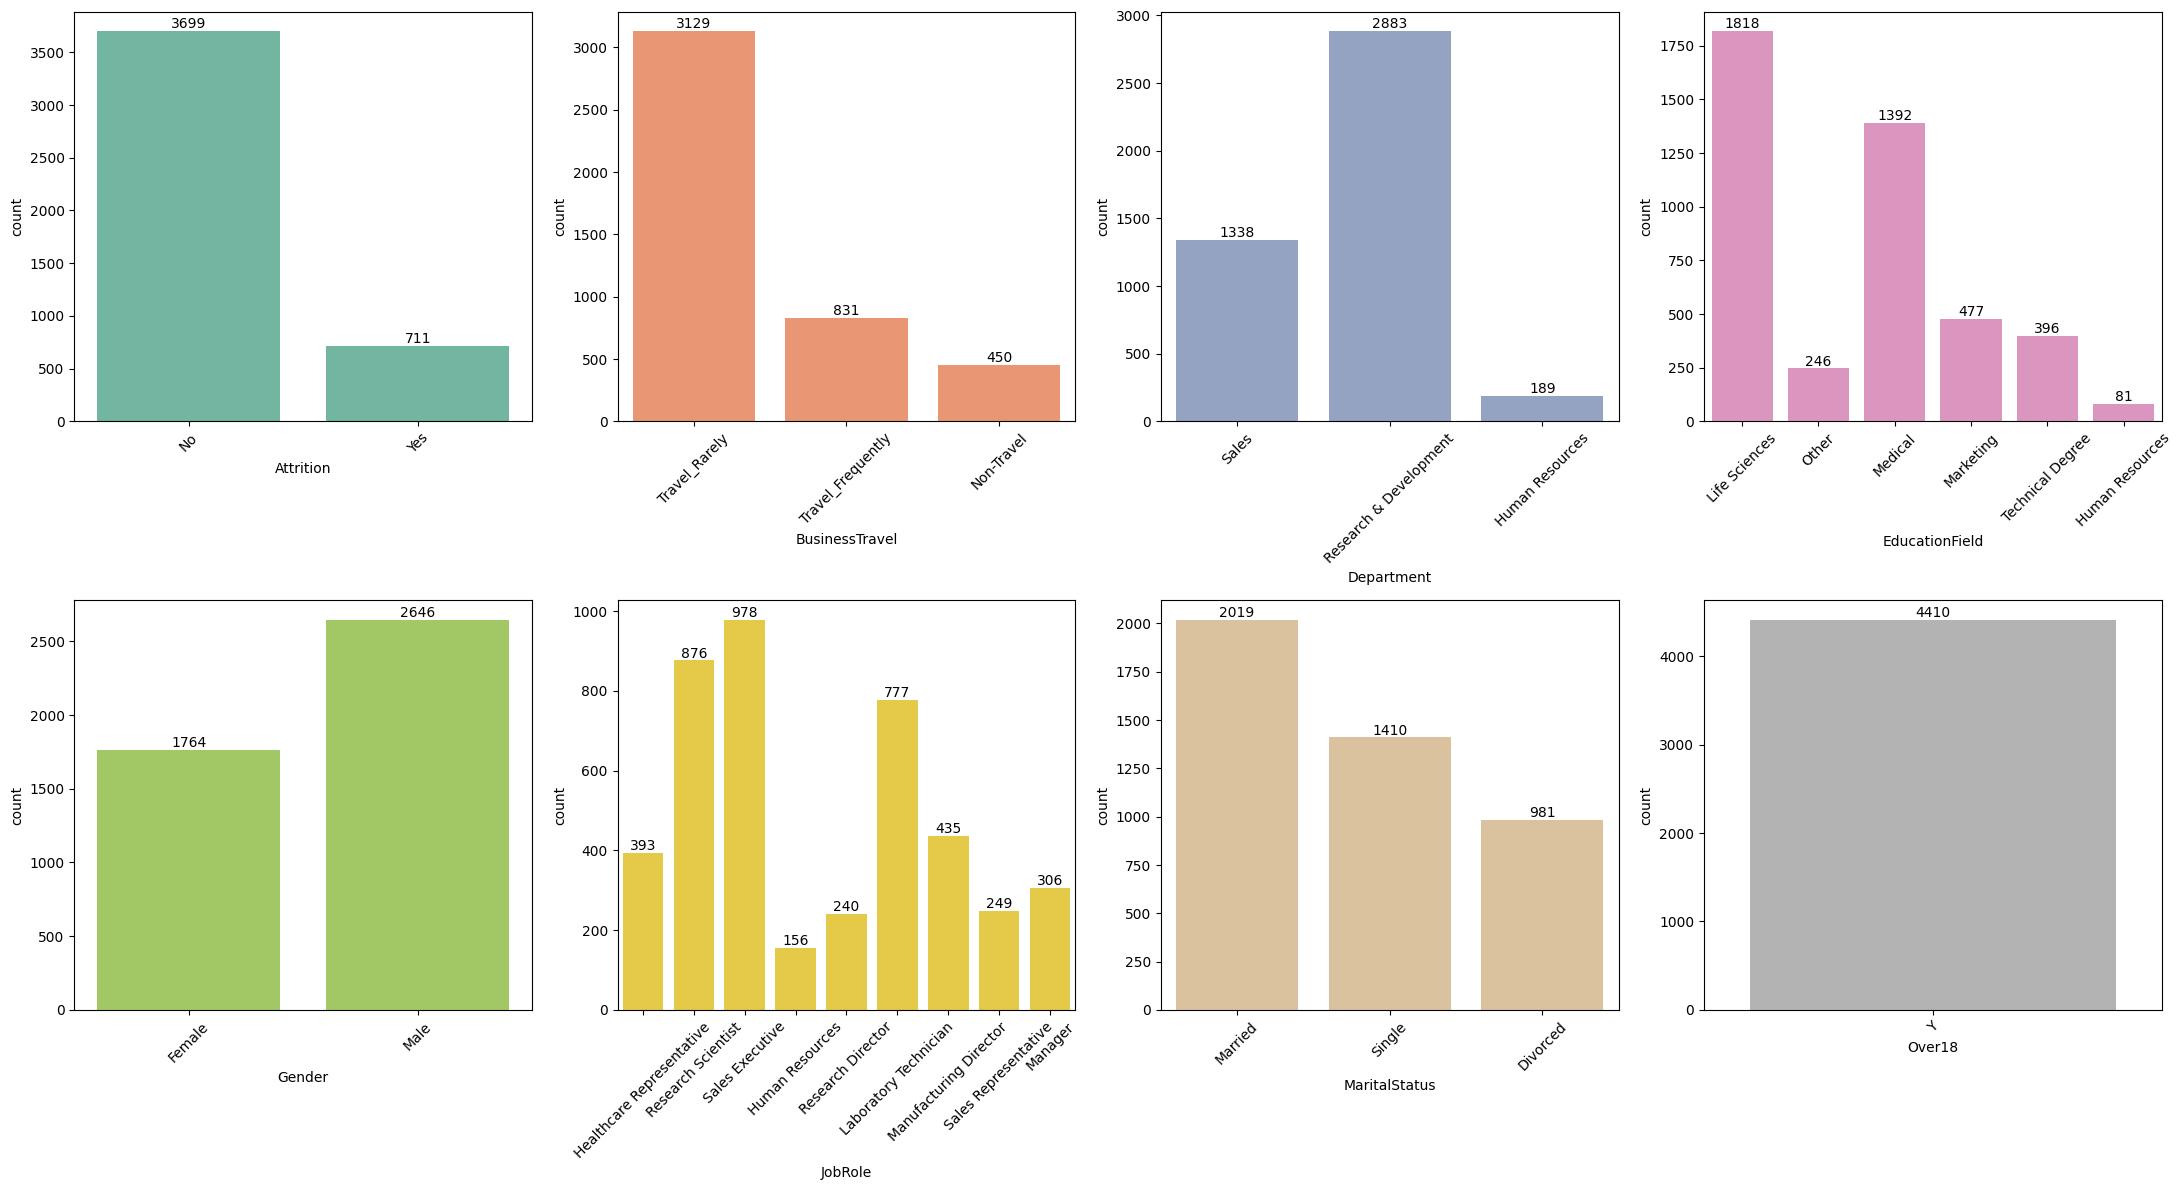

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

cat_cols = ['Attrition','BusinessTravel','Department','EducationField',
            'Gender','JobRole','MaritalStatus','Over18']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(22,12))
palette = sns.color_palette("Set2", len(cat_cols))

for i, col in enumerate(cat_cols):
    ax = axes[i//4, i%4]  # posición en la grilla

    # Asigno un color diferente para cada gráfico
    sns.countplot(x=col, data=df_imputado, ax=ax, color=palette[i])

    ax.tick_params(axis='x', rotation=45)

    # Añade las etiquetas a las barras de cada gráfico
    for container in ax.containers:
        ax.bar_label(container, label_type='edge')

# Ajustar espacios para que no se sobrepongan
plt.tight_layout()
plt.show()

**Análisis**
1. **Attrition** La mayoría de empleados se mantienen en la empresa
2. **BusinessTravel** La mayoría viaja poco, pero casi un 20% sí lo hace con frecuencia.
3. **Department** La empresa está muy enfocada en I+D y ventas. Recursos Humanos es minoritario.
4. **EducationField** La mayoría de empleados provienen de áreas científicas.
5. **Gender** Hay predominancia masculina.
6. **JobRole** La fuerza laboral está muy orientada a ventas y a actividades de investigación/ciencia aplicada.
7. **MaritalStatus** La mayoría está casada, pero hay un grupo considerable de solteros.
8. **Over18** 100% mayores de 18. No aporta variabilidad (columna poco útil para modelado).



## <font color='orange'> **Análisis univariado de Variables Numéricas**

El siguiente código selecciona todas las columnas numéricas del dataframe (int64 y float64) y las guarda en la lista num_cols. Así se identifican las variables cuantitativas con las que se pueden hacer análisis estadísticos y gráficos.

In [62]:
num_cols = df_imputado.select_dtypes(include=['int64','float64']).columns.tolist()
print(num_cols)

['Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating', 'mean_time']


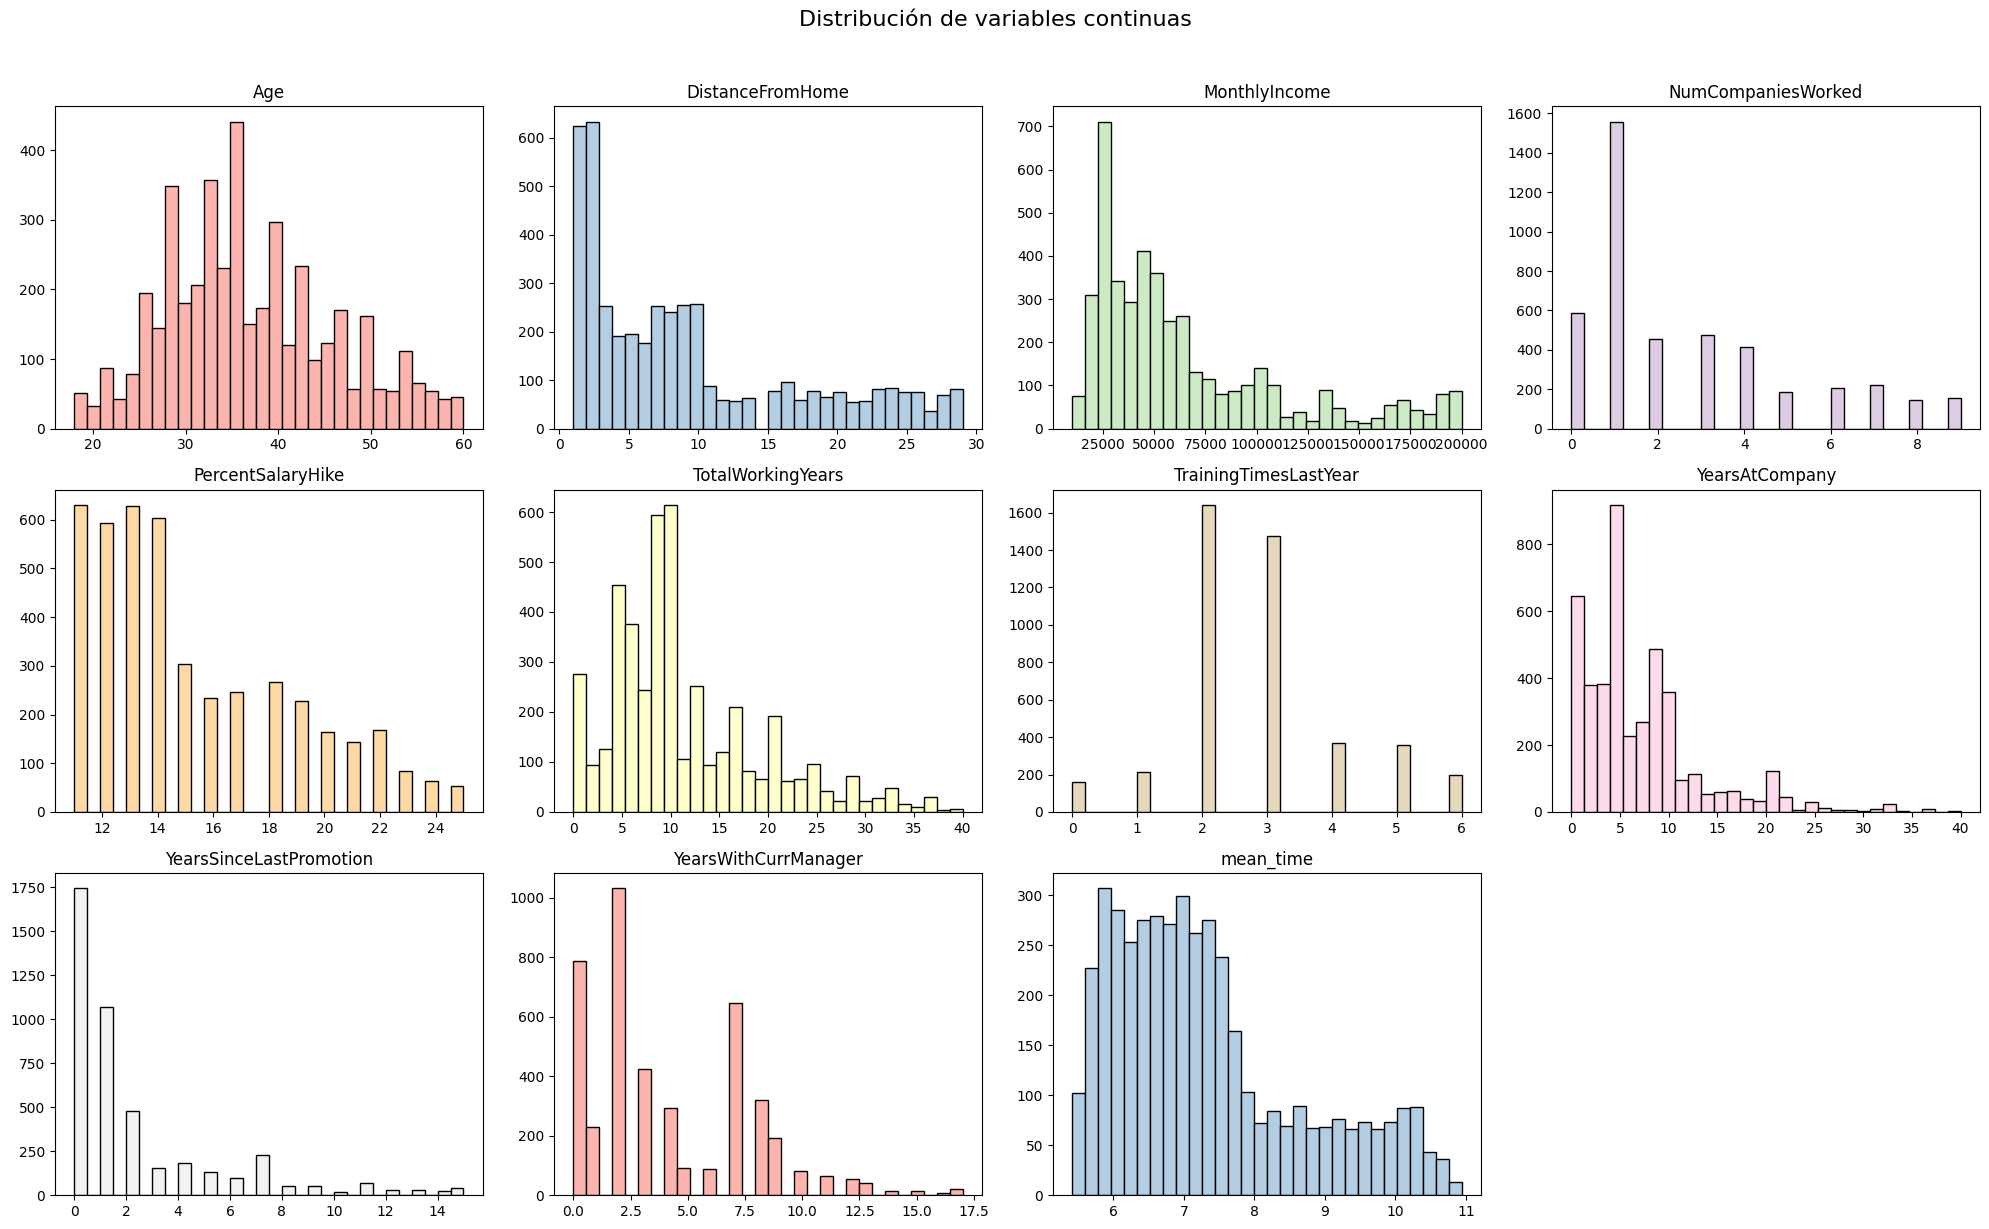

In [63]:
cont_vars = ['Age','DistanceFromHome','MonthlyIncome','NumCompaniesWorked',
             'PercentSalaryHike','TotalWorkingYears','TrainingTimesLastYear',
             'YearsAtCompany','YearsSinceLastPromotion','YearsWithCurrManager','mean_time']

fig, axes = plt.subplots(3, 4, figsize=(20,12))
palette = sns.color_palette("Pastel1", len(cont_vars))
for i, col in enumerate(cont_vars):
    ax = axes[i//4, i%4]
    n, bins, patches = ax.hist(df_imputado[col], bins=30, color=palette[i], edgecolor="black")
    ax.set_title(col)


# Ocultar subplots vacíos si sobran
for j in range(len(cont_vars), 12):
    fig.delaxes(axes.flatten()[j])

plt.suptitle("Distribución de variables continuas", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

***Análisis***

1.	**Age** Distribución relativamente simétrica (media ≈ mediana).
2.	**DistanceFromHome** Distribución sesgada a la derecha. Implica que la mayoría vive cerca del trabajo, pero hay un grupo pequeño con desplazamientos largos
3.	**MonthlyIncom** Asimetría positiva (unos pocos empleados con sueldos muy altos elevan la media).
4.	**NumCompaniesWorked** La mayoría ha trabajado en 1 compañías Valores altos podrían asociarse con mayor propensión a cambiar de empleo.
5.	**PercentSalaryHike** Relativamente equilibrado, con poca dispersión.
6.	**TotalWorkingYears** Distribución sesgada a la derecha: la mayoría tiene entre 5–15 años de experiencia, pero existen veteranos con más de 30–40 años.
7.	**TrainingTimesLastYear** La mayoría recibió entre 2 y 3 capacitaciones. Pocos empleados sin entrenamientos o con más de 5, lo que indica políticas formativas moderadas.
8.	**YearsAtCompany** Sesgo positivo: mayoría con permanencia corta-media, pero unos pocos muy antiguos (hasta 40 años).
9.	**YearsSinceLastPromotion** La mayoría fue ascendido recientemente (≤ 2 años).
10.	**YearsWithCurrManager** Mayoría con relaciones cortas-medianas, aunque algunos llevan más de 10 años con el mismo líder.
11.	**mean_time** Distribución centrada alrededor de la jornada estándar (7–8 h). Algunos casos extremos superan las 10 h, lo cual podría relacionarse con sobrecarga y menor balance vida-trabajo


## <font color='orange'> **Análisis Univariado de Variables Categóricas Ordinales**

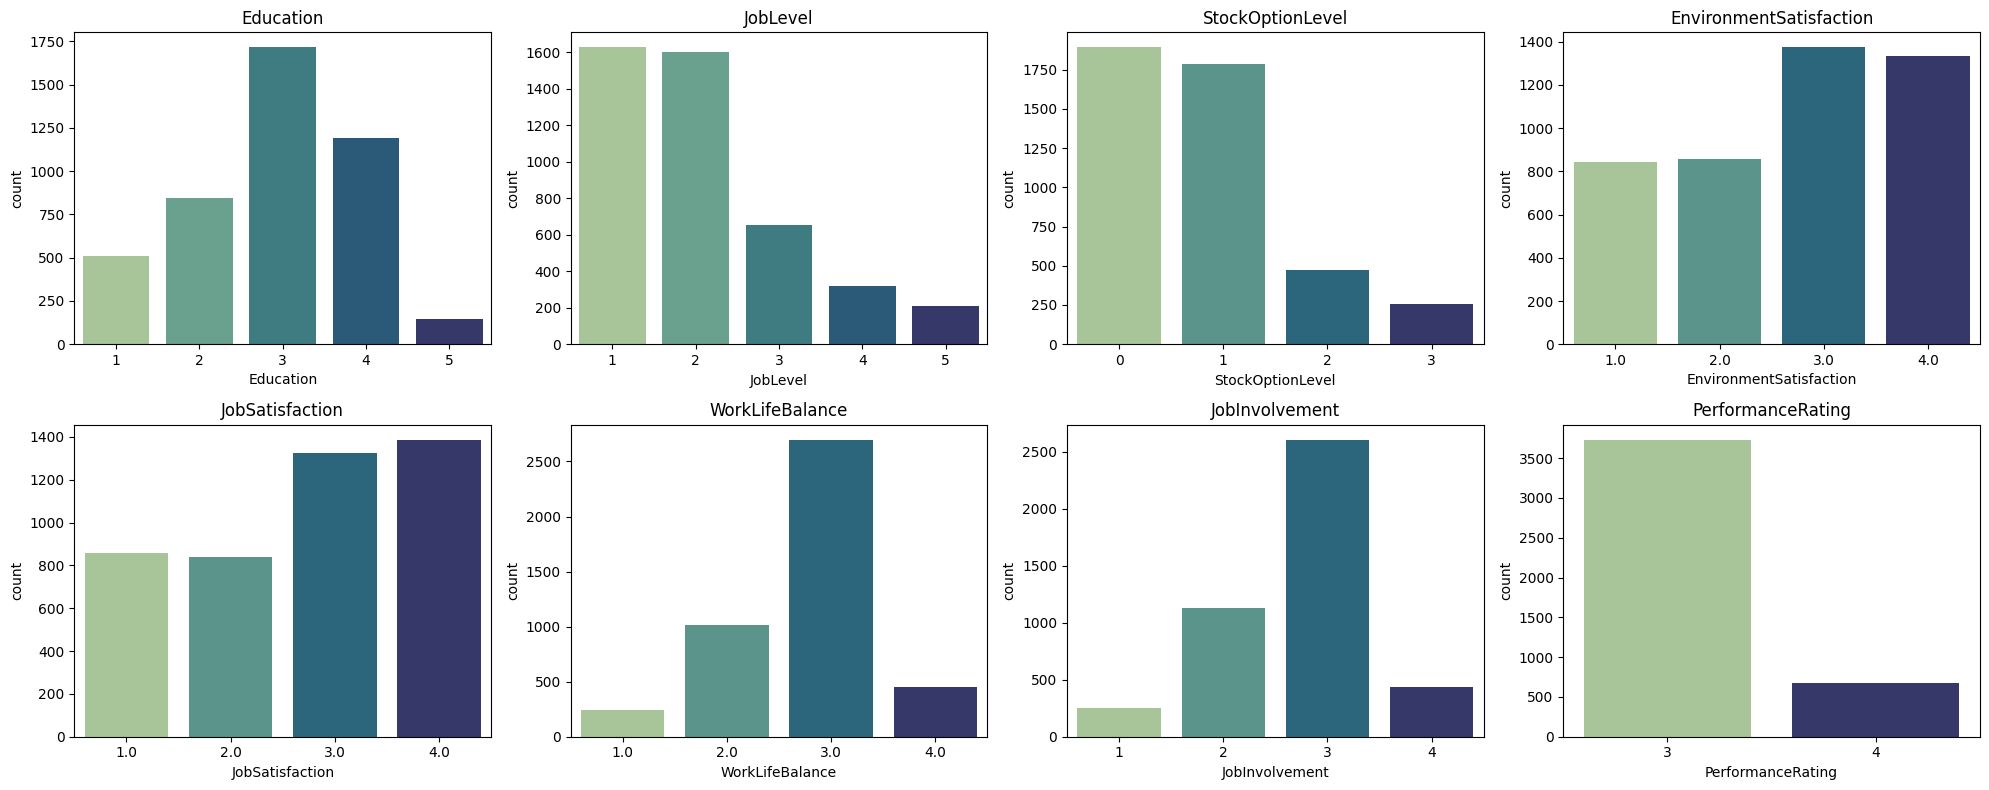

In [64]:
ord_vars = ['Education','JobLevel','StockOptionLevel','EnvironmentSatisfaction',
            'JobSatisfaction','WorkLifeBalance','JobInvolvement','PerformanceRating']

# Grilla de 2 filas x 4 columnas
fig, axes = plt.subplots(2, 4, figsize=(20,8))

for i, col in enumerate(ord_vars):
    ax = axes[i//4, i%4]
    sns.countplot(x=col, data=df_imputado, ax=ax, hue=col, palette="crest", legend=False)
    ax.set_title(col)
plt.tight_layout()
plt.show()

**1. Education**
La mayoría de los empleados tienen nivel 3 Esto muestra que la empresa tiene una fuerza laboral mayoritariamente con educación universitaria.

**2. JobLevel**
Estructura con muchos trabajadores en cargos bajos/medios y pocos en cargos altos.

**3. StockOptionLevel**
Casi el 83% de empleados están en nivel 0 o 1, lo que sugiere que los beneficios en acciones están poco distribuidos.

**4. EnvironmentSatisfaction**
Los valores están bastante equilibrados.

**5. JobSatisfaction**
Muy similar a la anterior, lo que muestra en general buena percepción del trabajo.

**6. WorkLifeBalance**
Este equilibrio es percibido como adecuado en general.

**7. JobInvolvement**
Predomina el nivel 3, con compromiso alto. Esto sugiere que la mayoría está medianamente comprometida.

**8. PerformanceRating**
Esto puede significar que las evaluaciones de desempeño son muy homogéneas, lo que limita la capacidad de diferenciar realmente el rendimiento.

## <font color='orange'> **Análisis Bivariado**

### **Correlación entre variables numéricas**

In [65]:
df_imputado.dtypes

,0
Age,int64
Attrition,object
BusinessTravel,object
Department,object
DistanceFromHome,int64
Education,int64
EducationField,object
EmployeeCount,int64
EmployeeID,int64
Gender,object


<Axes: >

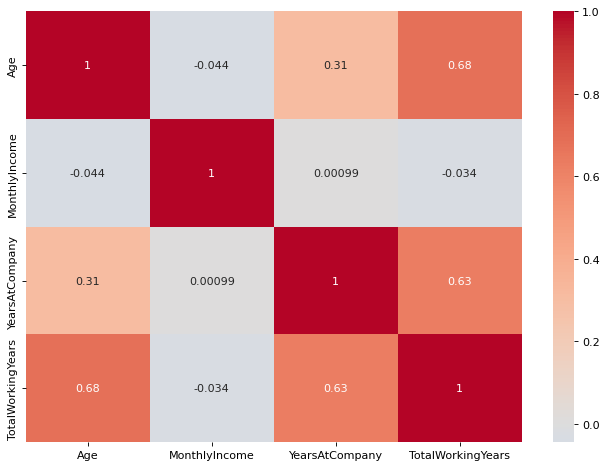

In [66]:
# variables numéricas de interés
cols_interes = ['Age', 'MonthlyIncome', 'YearsAtCompany', 'TotalWorkingYears']

figure(figsize=(10, 7), dpi=80)
sns.heatmap(df_imputado[cols_interes].corr(),annot=True,cmap="coolwarm",center=0)

Se muestra que Age y TotalWorkingYears están fuertemente correlacionadas, así como TotalWorkingYears y YearsAtCompany, lo que indica que la antigüedad general y el tiempo en la empresa están relacionados. Por otro lado, MonthlyIncome no presenta correlaciones significativas con las otras variables, lo que sugiere que aporta información independiente al modelo.

### **Prueba Chi-Cuadrado entre variables categóricas**



Con el fin de complementar el análisis exploratorio y las tablas de contingencia, se aplicó la **prueba Chi-Cuadrado de independencia** para evaluar si la variable objetivo **Attrition** está asociada con otras variables categóricas del dataset.

**Hipótesis:**
- H₀ (nula): no existe relación entre las variables (son independientes).
- H₁ (alternativa): existe relación significativa entre las variables.

**Criterio de decisión:**
- Si el valor de *p* ≤ 0.05, se rechaza H₀ y se concluye que existe relación significativa.
- Si el valor de *p* > 0.05, no hay evidencia suficiente de asociación.


In [67]:
from itertools import product
import scipy.stats as ss
# Seleccionar solo variables categóricas de interés
df_cat = df_imputado[["Attrition","Department","MaritalStatus",
                      "Education","JobRole","BusinessTravel"]].copy()

In [68]:
# Eliminar filas con nulos
df_cat_v1 = df_cat.dropna()

# Variables categóricas
cat_var1 = ('Attrition','Department','MaritalStatus','Education','JobRole','BusinessTravel')
cat_var2 = ('Attrition','Department','MaritalStatus','Education','JobRole','BusinessTravel')

# Crear combinaciones posibles
cat_var_prod = list(product(cat_var1, cat_var2, repeat=1))

In [69]:
# Guardar resultados
result = []
for i in cat_var_prod:
    if i[0] != i[1]:
        tabla = pd.crosstab(df_cat_v1[i[0]], df_cat_v1[i[1]])
        chi2, p, dof, expected = ss.chi2_contingency(tabla)
        result.append((i[0], i[1], p))


In [70]:
# Organizar resultados en DataFrame
pd.options.display.float_format = '{:.5f}'.format
chi_test_output = pd.DataFrame(result, columns=['var1','var2','p_valor'])

# Mostrar resultados en formato tabla
chi_test_output.pivot(index='var1', columns='var2', values='p_valor')

var2,Attrition,BusinessTravel,Department,Education,JobRole,MaritalStatus
var1,,,,,,
Attrition,NaN,0.00000,0.00000,0.22760,0.00149,0.00000
BusinessTravel,0.00000,NaN,0.00001,0.01802,0.04133,0.00016
Department,0.00000,0.00001,NaN,0.25425,0.02714,0.00010
Education,0.22760,0.01802,0.25425,NaN,0.00000,0.39860
JobRole,0.00149,0.04133,0.02714,0.00000,NaN,0.00001
MaritalStatus,0.00000,0.00016,0.00010,0.39860,0.00001,NaN


**Resultados obtenidos:**

- **Attrition vs BusinessTravel** → p = 0.00000  Relación significativa: la frecuencia de viajes está asociada con la rotación.  
- **Attrition vs Department** → p = 0.00000  Relación significativa: el área de trabajo influye en la rotación.  
- **Attrition vs Education** → p = 0.22760 No significativa: la educación no muestra un patrón claro en la rotación.  

- **Attrition vs JobRole** → p = 0.00149 Relación significativa: el cargo específico incide en la decisión de renuncia.  
- **Attrition vs MaritalStatus** → p = 0.00000 Relación significativa: el estado civil está asociado con la rotación (solteros presentan mayor salida).


El test de Chi-Cuadrado confirma que variables como **Department, JobRole, BusinessTravel y MaritalStatus** sí tienen asociación estadísticamente significativa con la permanencia de empleados.  
Por otro lado, **Education** no muestra relación significativa.

## <font color='orange'> **Attrition**





La variable objetivo `Attrition` está desbalanceada.
Alrededor del **84% de empleados permanecen** en la empresa, mientras que solo el **16% se retira**.

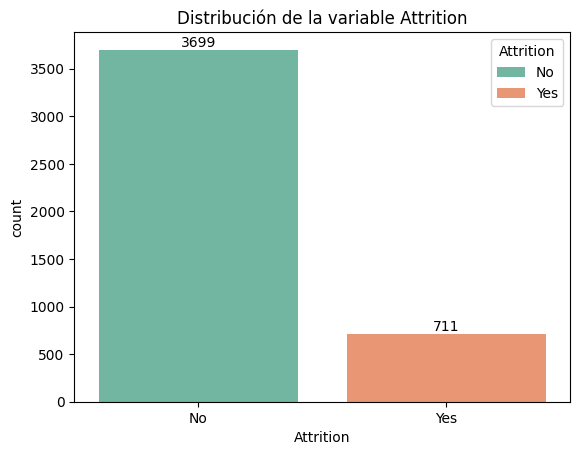

Attrition
No    83.87755
Yes   16.12245
Name: proportion, dtype: float64


In [71]:
sns.countplot(x="Attrition", data=df_imputado, hue="Attrition", palette="Set2", legend=True)
plt.title("Distribución de la variable Attrition")
for container in plt.gca().containers:
    plt.gca().bar_label(container, label_type='edge')
plt.show()

print(df_imputado["Attrition"].value_counts(normalize=True)*100)

In [72]:
def bivariado_attrition(df, var, tipo="numerica"):
    fig = make_subplots(rows=1, cols=2)

    if tipo=="numerica":
        mean_by_attrition = df.groupby('Attrition')[var].mean()
        fig.add_trace(
            go.Bar(
                x=mean_by_attrition.index,
                y=mean_by_attrition.values,
                text=np.round(mean_by_attrition.values, 2),
                textposition="outside",
                marker_color=['#AEC6CF', '#FFB347'],showlegend=False ), row=1, col=1)

        fig.add_trace(go.Box(
            y=df.loc[df['Attrition']=='No', var],
            name="No",marker_color='#AEC6CF'), row=1, col=2)

        fig.add_trace(go.Box(
            y=df.loc[df['Attrition']=='Yes', var],
            name="Yes",marker_color='#FFB347'), row=1, col=2)

    fig.update_layout(
        title_text=f"Attrition vs {var}",barmode='group',template='simple_white',
        showlegend=True,width=700,height=500,
        legend=dict(
            x=1,
            y=1,
            xanchor="left",
            yanchor="top"))
    return fig

### **Numéricas**

#### **Attrition vs Age**

In [73]:
fig = bivariado_attrition(df_imputado, "Age", tipo="numerica")
fig.show()

Las gráficas muestran que los empleados que se van son en promedio más jóvenes (33 años) que los que permanecen en la empresa (37 años). También aparecen algunos casos atípicos en quienes se van, con edades entre 56 y 58 años, lo que indica que, aunque la tendencia general apunta a los más jóvenes, también hay algunos empleados mayores que deciden salir.

#### **Attrition vs Distance from home**

In [74]:
fig = bivariado_attrition(df_imputado, "DistanceFromHome", tipo="numerica")
fig.show()

Las gráficas muestran que los empleados que se van tienen en promedio 9.0 kilómetros de distancia desde su casa al trabajo, mientras que quienes permanecen registran un promedio de 9.2 kilómetros, lo que indica que la cercanía o lejanía del lugar de residencia no marca una diferencia significativa en la decisión de permanecer o irse de la empresa.

#### **Attrition vs Monthly Income**

In [75]:
fig = bivariado_attrition(df_imputado, "MonthlyIncome", tipo="numerica")
fig.show()

Las gráficas muestran que, en general, los empleados que se quedan en la empresa reciben un ingreso mensual un poco más alto que los que se van, aunque la diferencia no es muy grande.

Además, aparecen algunos casos atípicos: personas con sueldos mucho más altos que el promedio. Estos casos se presentan tanto en quienes se quedan como en quienes renuncian, lo que nos puede indicar que ganar más dinero no siempre asegura que el empleado permanezca en la empresa.

#### **Attrition vs Num companies worked**

In [76]:
fig = bivariado_attrition(df_imputado, "NumCompaniesWorked", tipo="numerica")
fig.show()

Las gráficas muestran que los empleados que se van han trabajado en promedio en más empresas (3) que quienes permanecen (2.6), lo que sugiere una mayor movilidad laboral en este grupo. Además, se identifican casos atípicos en los empleados que permanecen, con un número máximo de 9 empresas previas, lo que refleja trayectorias laborales poco comunes dentro de la organización.

#### **Attrition vs Percent Salary Hike**

In [77]:
fig = bivariado_attrition(df_imputado, "PercentSalaryHike", tipo="numerica")
fig.show()

Las gráficas muestran que el porcentaje de incremento salarial es muy similar entre los empleados que se van (15.5%) y los que permanecen (15.2%), sin diferencias relevantes. No se identifican valores atípicos en esta variable, lo que indica que los aumentos salariales se distribuyen de manera homogénea en ambos grupos.

#### **Attrition vs Total Working Years**

In [78]:
fig = bivariado_attrition(df_imputado, "TotalWorkingYears", tipo="numerica")
fig.show()

Las gráficas muestran que los empleados que se van tienen en promedio menos años de experiencia laboral total (8) que quienes permanecen en la empresa (12), lo que sugiere que la permanencia está más asociada a trayectorias profesionales más largas. Además, se identifican valores atípicos: en quienes permanecen, con experiencias de 32 a 38 años, y en quienes se van, con trayectorias entre 21 y 40 años, reflejando casos poco comunes de empleados con carreras laborales muy extensas.

#### **Attrition vs Training Times Last Year**

In [79]:
fig = bivariado_attrition(df_imputado, "TrainingTimesLastYear", tipo="numerica")
fig.show()

Las gráficas muestran que la cantidad de capacitaciones recibidas en el último año es muy similar entre quienes se quedan (2.8) y quienes se van (2.6). Sin embargo, aparecen valores atípicos en ambos grupos, principalmente en empleados con 0 o hasta 6 entrenamientos, lo que refleja que existen casos poco frecuentes de ausencia total o de participación muy alta en programas de formación.

#### **Attrition vs Years At Company**

In [80]:
fig = bivariado_attrition(df_imputado, "YearsAtCompany", tipo="numerica")
fig.show()

Las gráficas muestran que los empleados que se van tienen en promedio menos años en la empresa (5) que quienes permanecen (7), lo que sugiere que la permanencia está más asociada con una mayor antigüedad. También se identifican casos atípicos en ambos grupos: en quienes se quedan, con trayectorias de 21 a 37 años, y en quienes se van, con entre 17 y 40 años en la organización, reflejando situaciones poco comunes de empleados con mucha antigüedad.

#### **Attrition vs Years Since Last Promotion**

In [81]:
fig = bivariado_attrition(df_imputado, "YearsSinceLastPromotion", tipo="numerica")
fig.show()

Las gráficas muestran que los empleados que se van tienen en promedio menos tiempo desde su último ascenso (5 años) que quienes permanecen en la empresa (7 años). Además, se observan casos atípicos en ambos grupos, con periodos muy largos sin ascenso: entre 21 y 37 años en los que permanecen, y entre 17 y 40 años en los que se van, lo que evidencia trayectorias poco comunes de empleados con largos intervalos sin ascensos.

#### **Attrition vs Years With Curr Manager**

In [82]:
fig = bivariado_attrition(df_imputado, "YearsWithCurrManager", tipo="numerica")
fig.show()

Las gráficas muestran que quienes permanecen en la empresa tienden a llevar más tiempo trabajando con su jefe actual (4 años en promedio) en comparación con quienes se van (3 años). Esto sugiere que la estabilidad en la relación con el jefe podría estar asociada a una mayor permanencia. Además, se identifican algunos casos atípicos de empleados que llevan más de 14 años con el mismo jefe, aunque son poco frecuentes.

#### **Attrition vs Mean Time**

In [83]:
fig = bivariado_attrition(df_imputado, "mean_time", tipo="numerica")
fig.show()

Las gráficas muestran que los empleados que se van presentan en promedio un mayor tiempo de trabajo diario que quienes permanecen. Esto sugiere que jornadas más largas podrían estar asociadas con la decisión de dejar la empresa, posiblemente por factores de carga laboral o equilibrio entre vida y trabajo.

### **Categóricas**

#### **Attrition vs JobRole**

In [84]:
pd.crosstab(df_imputado["JobRole"], df_imputado["Attrition"], normalize="index")*100

Attrition,No,Yes
JobRole,,
Healthcare Representative,85.49618,14.50382
Human Resources,86.53846,13.46154
Laboratory Technician,83.78378,16.21622
Manager,86.27451,13.72549
Manufacturing Director,88.96552,11.03448
Research Director,76.25000,23.75000
Research Scientist,81.84932,18.15068
Sales Executive,83.12883,16.87117
Sales Representative,85.54217,14.45783


El análisis evidencia que la salida de la empresa no afecta por igual a todos los roles, lo que indica que el cargo desempeñado es un factor relevante para predecir la decisión de los empleados. Los puestos más técnicos o de investigación y ventas concentran mayores tasas de abandono, mientras que los de dirección muestran mayor estabilidad.

#### **Attrition vs BusinessTravel**

In [85]:
pd.crosstab(df_imputado["BusinessTravel"],df_imputado["Attrition"],normalize="index")*100

Attrition,No,Yes
BusinessTravel,,
Non-Travel,92.00000,8.00000
Travel_Frequently,75.09025,24.90975
Travel_Rarely,85.04314,14.95686


Se evidencia que los empleados que no viajan tienden a mantener más su posición en la empresa, mientras que los que viajan frecuentemente o rara vez, tienden a desistir de su trabajo.

#### **Attrition vs Department**


In [86]:
pd.crosstab(df_imputado['Department'], df_imputado['Attrition'], normalize='index')*100

Attrition,No,Yes
Department,,
Human Resources,69.84127,30.15873
Research & Development,84.28720,15.71280
Sales,84.97758,15.02242


Se observa que el área de Recursos Humanos presenta una proporción considerablemente más alta de empleados que dejan la organización en comparación con los departamentos de Ventas e Investigación y Desarrollo, donde la estabilidad resulta mayor.

#### **Attrition vs Marital Status**

In [87]:
pd.crosstab(df_imputado['MaritalStatus'], df_imputado['Attrition'], normalize='index')*100

Attrition,No,Yes
MaritalStatus,,
Divorced,89.90826,10.09174
Married,87.51857,12.48143
Single,74.46809,25.53191


Se muestra que los empleados solteros presentan una mayor propensión a abandonar la empresa frente a los casados o divorciados, quienes reflejan mayor permanencia en sus puestos.

#### **Attrition vs Education**


In [88]:
pd.crosstab(df_imputado['Education'], df_imputado['Attrition'], normalize='index')*100

Attrition,No,Yes
Education,,
1,84.70588,15.29412
2,81.20567,18.79433
3,84.44056,15.55944
4,84.42211,15.57789
5,85.41667,14.58333


Se observa que el nivel educativo no presenta diferencias marcadas en la permanencia o salida de los empleados, lo que indica que este factor no es un determinante fuerte en la decisión de continuar en la empresa.

#### **Attrition vs EducationField**

In [89]:
pd.crosstab(df_imputado['EducationField'], df_imputado['Attrition'], normalize='index')*100

Attrition,No,Yes
EducationField,,
Human Resources,59.25926,40.74074
Life Sciences,83.33333,16.66667
Marketing,84.27673,15.72327
Medical,83.83621,16.16379
Other,87.80488,12.19512
Technical Degree,88.63636,11.36364


Se muestra que el campo de formación influye en la permanencia, destacando que los empleados de Recursos Humanos presentan la mayor proporción de salidas, mientras que quienes tienen formación técnica u “otros” campos muestran mayor estabilidad dentro de la empresa.

#### **Attrition vs Enviroment Satisfaction**

In [90]:
pd.crosstab(df_imputado['EnvironmentSatisfaction'], df_imputado['Attrition'], normalize='index')*100

Attrition,No,Yes
EnvironmentSatisfaction,,
1.00000,74.79290,25.20710
2.00000,85.04673,14.95327
3.00000,86.10909,13.89091
4.00000,86.58171,13.41829


Se evidencia que un menor nivel de satisfacción con el entorno laboral está asociado con una mayor proporción de salidas, mientras que a medida que la satisfacción aumenta, la permanencia en la empresa es más alta.

#### **Attrition vs Gender**

In [91]:
pd.crosstab(df_imputado['Gender'], df_imputado['Attrition'], normalize='index')*100

Attrition,No,Yes
Gender,,
Female,84.69388,15.30612
Male,83.33333,16.66667


Se observa que la diferencia entre hombres y mujeres es mínima, lo que indica que el género no representa un factor determinante en la permanencia o salida de los empleados.

#### **Attrition vs Job Involvement**

In [92]:
pd.crosstab(df_imputado['JobInvolvement'], df_imputado['Attrition'], normalize='index')*100

Attrition,No,Yes
JobInvolvement,,
1,78.31325,21.68675
2,84.00000,16.00000
3,84.67742,15.32258
4,81.94444,18.05556


Se muestra que los empleados con menor nivel de implicación en el trabajo presentan una mayor tendencia a abandonar la empresa, mientras que en niveles intermedios la permanencia es más alta, lo que resalta la importancia del compromiso laboral en la decisión de continuar.

#### **Attrition vs Job Satisfaction**

In [93]:
pd.crosstab(df_imputado['JobSatisfaction'], df_imputado['Attrition'], normalize='index')*100

Attrition,No,Yes
JobSatisfaction,,
1.00000,77.09302,22.90698
2.00000,83.57143,16.42857
3.00000,83.44671,16.55329
4.00000,88.68061,11.31939


Se observa que los empleados con baja satisfacción en su trabajo presentan una mayor propensión a dejar la empresa, mientras que quienes reportan altos niveles de satisfacción muestran una permanencia significativamente mayor.

#### **Attrition vs Job Level**

In [94]:
pd.crosstab(df_imputado['JobLevel'], df_imputado['Attrition'], normalize='index')*100

Attrition,No,Yes
JobLevel,,
1,84.53039,15.46961
2,82.20974,17.79026
3,85.32110,14.67890
4,83.96226,16.03774
5,86.95652,13.04348


Se muestra que los empleados en niveles intermedios de la jerarquía tienden a presentar una mayor probabilidad de salida, mientras que en los niveles más altos se percibe mayor estabilidad.

#### **Attrition vs PerformanceRating**

In [95]:
pd.crosstab(df_imputado['PerformanceRating'], df_imputado['Attrition'], normalize='index')*100

Attrition,No,Yes
PerformanceRating,,
3,84.24437,15.75563
4,81.85841,18.14159


Se muestra que los empleados con evaluaciones de desempeño más altas también presentan una mayor probabilidad de salida, lo que sugiere que un buen rendimiento no necesariamente garantiza la permanencia en la empresa.

#### **Attrition vs Stock Option Level**

In [96]:
pd.crosstab(df_imputado['StockOptionLevel'], df_imputado['Attrition'], normalize='index')*100

Attrition,No,Yes
StockOptionLevel,,
0,83.20127,16.79873
1,84.89933,15.10067
2,82.27848,17.72152
3,84.70588,15.29412


Se aprecia que los diferentes niveles de opciones sobre acciones no generan una diferencia marcada en la permanencia, aunque quienes no cuentan con este beneficio tienden a mostrar una ligera mayor propensión a abandonar la empresa.


#### **Attrition vs Work Life Balance**

In [97]:
pd.crosstab(df_imputado['WorkLifeBalance'], df_imputado['Attrition'], normalize='index')*100

Attrition,No,Yes
WorkLifeBalance,,
1.00000,68.61925,31.38075
2.00000,83.21884,16.78116
3.00000,85.76723,14.23277
4.00000,82.15859,17.84141


Se observa que un bajo nivel de equilibrio entre la vida laboral y personal está asociado con una mayor proporción de salidas, mientras que los empleados con mejor balance tienden a permanecer más tiempo en la empresa.

# **Datos Atipicos**

Para términos de análisis y de ver los datos atípicos, primero se hacen boxplot con el umbral determinado de 1.5 para entender y poder tratar este parte de los datos.

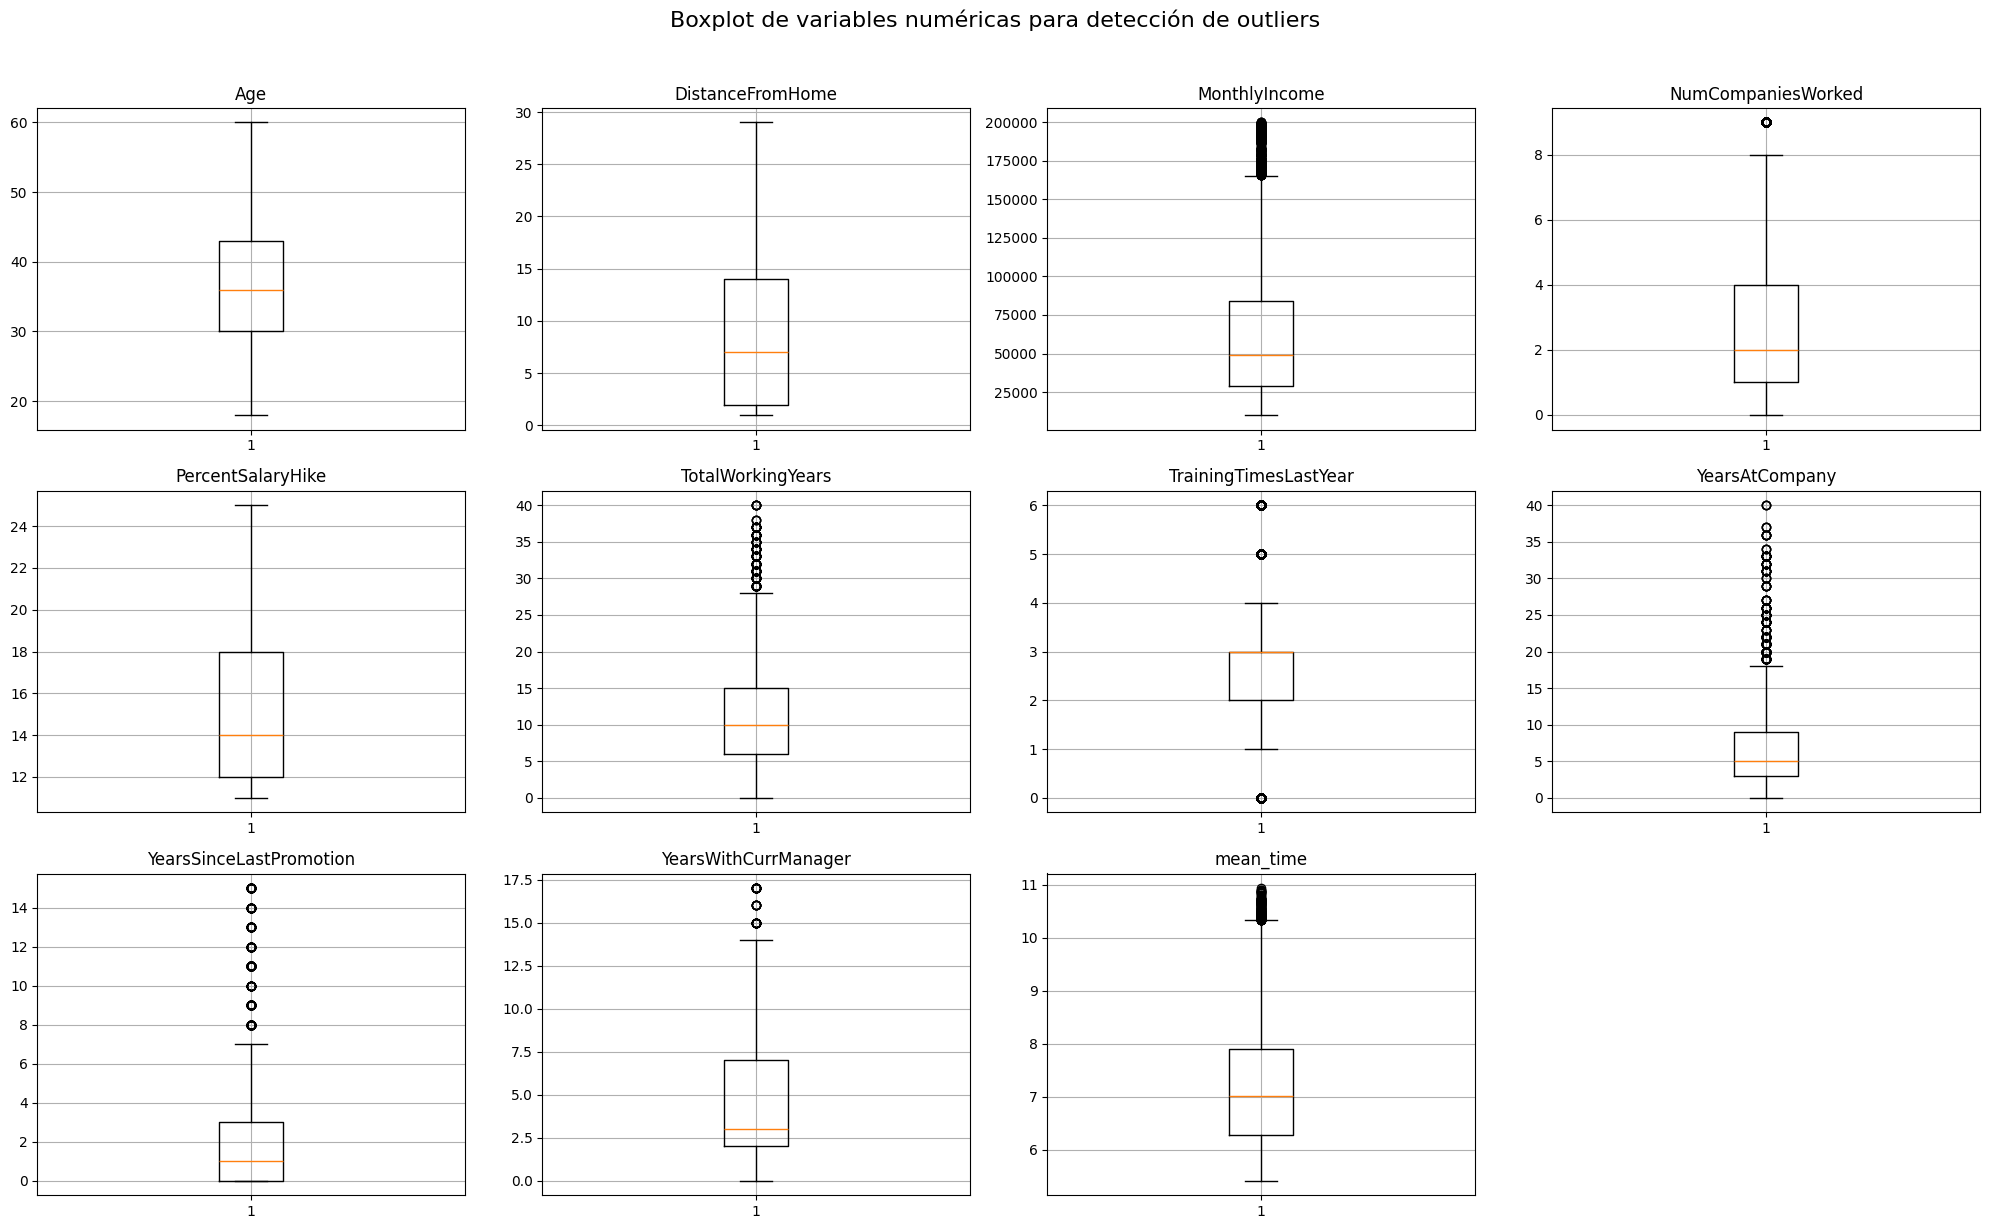

In [98]:
import matplotlib.pyplot as plt

variables_numericas = ['Age','DistanceFromHome','MonthlyIncome','NumCompaniesWorked',
             'PercentSalaryHike','TotalWorkingYears','TrainingTimesLastYear',
             'YearsAtCompany','YearsSinceLastPromotion','YearsWithCurrManager','mean_time']

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20,12))

for i, col in enumerate(variables_numericas):
    ax = axes[i//4, i%4]
    ax.boxplot(df_imputado[col])
    ax.set_title(col)
    ax.grid(True)

for j in range(len(variables_numericas), 12): # Ocultar los subplots vacíos si sobran
    fig.delaxes(axes.flatten()[j])

plt.suptitle("Boxplot de variables numéricas para detección de outliers", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Cuando usamos 1.5·IQR, los boxplots muestran varios outliers en casi todas las variables:



| Variable                  | Outliers detectados | Comentario                                                                 |
|----------------------------|-------------------|---------------------------------------------------------------------------|
| **Age**                    | No                | No presenta valores extremos; distribución estable.                       |
| **DistanceFromHome**       | No                | Sin outliers; comportamiento homogéneo.                                   |
| **MonthlyIncome**          | Sí                | Concentrados en ingresos muy altos; podrían sesgar el modelo.             |
| **NumCompaniesWorked**     | Sí                | Outliers en empleados con muchas experiencias previas (≥9 empresas).      |
| **PercentSalaryHike**      | No                | Variable estable; sin valores fuera de rango esperado.                    |
| **TotalWorkingYears**      | Sí                | Outliers en personas con más de 30 años de experiencia laboral.           |
| **TrainingTimesLastYear**  | Sí                | Alta proporción de outliers; empleados con entrenamientos muy repetidos o nulos. |
| **YearsAtCompany**         | Sí                | Casos atípicos en empleados con permanencias muy largas.                  |
| **YearsSinceLastPromotion**| Sí                | Outliers en empleados con periodos muy largos sin promoción.              |
| **YearsWithCurrManager**   | Sí                | Casos puntuales de relaciones laborales muy extensas con un mismo jefe.  |
| **mean_time**              | Sí                | Pocos outliers en tiempos medios de permanencia o gestión.                |



Primero se exploraron outliers con el criterio de 1.5·IQR para identificar valores atípicos moderados y extremos. Sin embargo, dado que muchos de estos representan situaciones reales (ej. salarios altos, antigüedad laboral), se optó por un umbral más estricto de 3·IQR para enfocarse únicamente en outliers extremos.

## **Tratamiento de Atipicos**

Se calcularon los cuartiles (Q1 y Q3) y el rango intercuartílico (IQR = Q3 – Q1).

Los límites se definieron como:

**Inferior:** Q1 – 3*IQR

**Superior:** Q3 + 3*IQR

Este umbral de 3*IQR es más estricto que el usual 1.5*IQR y se utiliza para identificar solo outliers extremos que realmente podrían sesgar el modelo.

In [99]:
import numpy as np

# Función para detectar outliers con IQR
def detectar_outliers_iqr(serie):
    Q1 = np.percentile(serie, 25)   # primer cuartil
    Q3 = np.percentile(serie, 75)   # tercer cuartil
    IQR = Q3 - Q1                   # rango intercuartílico

    lim_inf = Q1 - 3 * IQR # umbral 3: valores atipicos extremos
    lim_sup = Q3 + 3 * IQR

    outliers = serie[(serie < lim_inf) | (serie > lim_sup)]
    return outliers, lim_inf, lim_sup

for col in variables_numericas:
    outliers, li, ls = detectar_outliers_iqr(df_imputado[col])

    print(f"\nVariable: {col}")
    print("Posiciones de outliers:", outliers.index.tolist())
    print("Valores de outliers:", outliers.values.tolist())
    print("Número de outliers:", len(outliers))


Variable: Age
Posiciones de outliers: []
Valores de outliers: []
Número de outliers: 0

Variable: DistanceFromHome
Posiciones de outliers: []
Valores de outliers: []
Número de outliers: 0

Variable: MonthlyIncome
Posiciones de outliers: []
Valores de outliers: []
Número de outliers: 0

Variable: NumCompaniesWorked
Posiciones de outliers: []
Valores de outliers: []
Número de outliers: 0

Variable: PercentSalaryHike
Posiciones de outliers: []
Valores de outliers: []
Número de outliers: 0

Variable: TotalWorkingYears
Posiciones de outliers: []
Valores de outliers: []
Número de outliers: 0

Variable: TrainingTimesLastYear
Posiciones de outliers: []
Valores de outliers: []
Número de outliers: 0

Variable: YearsAtCompany
Posiciones de outliers: [12, 153, 215, 219, 303, 337, 395, 491, 656, 660, 704, 828, 853, 858, 880, 1310, 1338, 1402, 1449, 1482, 1623, 1685, 1689, 1773, 1807, 1865, 1961, 2126, 2130, 2174, 2298, 2323, 2328, 2350, 2780, 2808, 2872, 2919, 2952, 3093, 3155, 3159, 3243, 3277, 3

In [100]:
for col in variables_numericas:
    outliers, li, ls = detectar_outliers_iqr(df_imputado[col])
    if len(outliers) > 0:  # solo muestra si hay outliers
        porcentaje = round((len(outliers) / df_imputado.shape[0]) * 100, 2)
        print(f"{col}: {porcentaje}% de outliers")
    else:
        pass

YearsAtCompany: 1.29% de outliers
YearsSinceLastPromotion: 2.18% de outliers


Al aplicar este criterio, se encontró que:

La mayoría de variables no tienen valores atípicos extremos.

Solo YearsAtCompany (1.29%) y YearsSinceLastPromotion (2.18%) presentaron outliers.

### **Winsorización**

Para el tratamiento, se aplicó la técnica de **Winsorización**:

Consiste en reemplazar los valores atípicos extremos por el valor del límite inferior o superior según corresponda.

De esta forma, no se eliminan registros y se reduce el impacto de valores muy extremos en el modelo.

In [101]:
import numpy as np

# Función para winsorizar con método IQR
def winsorize_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 3 * IQR
    lim_sup = Q3 + 3 * IQR

    # Reemplazar valores fuera de rango por los límites
    return np.where(series < lim_inf, lim_inf,
                    np.where(series > lim_sup, lim_sup, series))

df_wins = df_imputado.copy()
variables_numericas = ['YearsAtCompany','YearsSinceLastPromotion']

# Aplicar winsorización a cada variable numérica
for col in variables_numericas:
    df_wins[col] = winsorize_iqr(df_wins[col])

**Comparación Antes y Después**

In [102]:
for col in ['YearsAtCompany','YearsSinceLastPromotion']:
    print(f"\n    {col}    ")
    resumen = pd.DataFrame({
        "Antes": df_imputado[col].describe(),
        "Después": df_wins[col].describe()
    })
    print(resumen)


    YearsAtCompany    
           Antes    Después
count 4410.00000 4410.00000
mean     7.00816    6.93197
std      6.12514    5.82409
min      0.00000    0.00000
25%      3.00000    3.00000
50%      5.00000    5.00000
75%      9.00000    9.00000
max     40.00000   27.00000

    YearsSinceLastPromotion    
           Antes    Después
count 4410.00000 4410.00000
mean     2.18776    2.14218
std      3.22170    3.06132
min      0.00000    0.00000
25%      0.00000    0.00000
50%      1.00000    1.00000
75%      3.00000    3.00000
max     15.00000   12.00000


Con la winsorización aplicada con umbral de 3, solo las variables YearsAtCompany y YearsSinceLastPromotion se ajustaron, reduciendo sus valores máximos y la dispersión, pero manteniendo iguales sus medianas y cuartiles. Esto significa que se controlaron los valores extremos sin alterar la tendencia general de los datos, lo que mejora la calidad del análisis y evita que el modelo se sesgue por casos poco comunes.

# **Conclusiones del EDA**

El análisis exploratorio permitió identificar los siguientes hallazgos clave:

- **Balance de clases**: La variable objetivo `Attrition` está desbalanceada.
  Alrededor del **84% de empleados permanecen** en la empresa, mientras que solo el
  **16% se retira**.

- **Multicolinealidad**
  - La variable `TotalWorkingYears` por presentar una correlación alta con otras variables, se puede excliur del modelo.
- **Factores numéricos**:
  - La variable `DistanceFromHome` no es relevante en la explicación de la variable objetivo.
  - La variable `PercentSalaryHike`presenta una distribución similar tanto para los empleados que se van como los que se quedan, por lo que no es una variable relevante en nuestro modelo.
  - La variable `TrainingTimesLastYear`no aporta mucho a la construcción del modelo.

- **Factores categóricos**:
  - La variable `Education`no aporta mucho al entendimiento de nuestro objetivo.
  - La variable `Gender` no brinda información relavante al modelo.
  - La variable `StockOptionLevel`no aporta significancia al modelo.

- **Outliers**: Se detectaron casos con más de 30 años de experiencia laboral e  **ingresos muy elevados**. Aunque son pocos, es importante considerarlos.

- **Variables eliminadas**
EmployeeID, EmployeeCount, StandardHours y Over18 fueron descartadas porque no aportan información predictiva (tienen un único valor o son solo identificadores). Por otro lado variables como DistanceFromHome, PercentSalaryHike, TrainingTimesLastYear, Education, Gender y StockOptionLevel también se eliminaran ya que no presentan significancia en la predicción del modelo.

- **Transformaciones de variables**
La variable mean_time fue corregida (estaba como texto con comas en lugar de puntos decimales) y transformada a tipo numérico.

**En conclusión,** la rotación de empleados parece estar asociada principalmente a
factores de **edad, ingresos, antigüedad** y **percepción de satisfacción**, además de
ciertas diferencias entre departamentos y estados civiles. Estos hallazgos orientarán
la selección de variables y la construcción de modelos supervisados.


# <font color='PURPLE'>**c. Preparación de los datos y selección de variables**

## <font color='orange'> **Variable Objetivo**

La variable que definimos como objetivo para nuestro caso es `Attrition` ya que según la descripción se acomoda mucho mejor con lo que estamos buscando tratar. Mencionando también que es una variable de clasificación por lo que se pretende usar regresión logística para su modelado.

## <font color='orange'> **Variables a eliminar**

Al revisar las columnas se encontró lo siguiente:

- **EmployeeID** → tiene un valor único por cada empleado (4410 valores distintos).  
  Es solo un identificador y no ayuda a predecir la rotación.  

- **EmployeeCount**, **StandardHours** y **Over18** → tienen un único valor para
  todos los empleados. Al no variar, no aportan información al modelo.  

Por esta razón, estas cuatro columnas se eliminarán en la preparación de los datos,
manteniendo solo las variables que realmente pueden ayudar a explicar o predecir
la variable objetivo (`Attrition`).

In [103]:
#   columnas constantes y id
cols_constantes = ["EmployeeID","EmployeeCount","StandardHours","Over18"]

for col in cols_constantes:
    print(f"{col} → valores únicos: {df_imputado[col].nunique()}")

EmployeeID → valores únicos: 4410
EmployeeCount → valores únicos: 1
StandardHours → valores únicos: 1
Over18 → valores únicos: 1


Ahora se procede a eliminar las variables que no aportan a la predicción del modelo.

In [104]:
#   columnas constantes y id
cols_variables = ["TotalWorkingYears","DistanceFromHome","PercentSalaryHike","TrainingTimesLastYear",
                  "Education","Gender","StockOptionLevel"]

for col in cols_variables:
    print(f"{col} → valores únicos: {df_imputado[col].nunique()}")

TotalWorkingYears → valores únicos: 40
DistanceFromHome → valores únicos: 29
PercentSalaryHike → valores únicos: 15
TrainingTimesLastYear → valores únicos: 7
Education → valores únicos: 5
Gender → valores únicos: 2
StockOptionLevel → valores únicos: 4


In [105]:
df_imputado1 = df_imputado.drop(columns=cols_constantes).drop(columns=cols_variables)
df_imputado1.shape

(4410, 19)

In [106]:
df_imputado1.head(5)

,Age,Attrition,BusinessTravel,Department,EducationField,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,mean_time
0,51,No,Travel_Rarely,Sales,Life Sciences,1,Healthcare Representative,Married,131160,1.00000,1,0,0,3.00000,4.00000,2.00000,3,3,6.87020
1,31,Yes,Travel_Frequently,Research & Development,Life Sciences,1,Research Scientist,Single,41890,0.00000,5,1,4,3.00000,2.00000,4.00000,2,4,7.31600
2,32,No,Travel_Frequently,Research & Development,Other,4,Sales Executive,Married,193280,1.00000,5,0,3,2.00000,2.00000,1.00000,3,3,6.81610
3,38,No,Non-Travel,Research & Development,Life Sciences,3,Human Resources,Married,83210,3.00000,8,7,5,4.00000,4.00000,3.00000,2,3,6.78920
4,32,No,Travel_Rarely,Research & Development,Medical,1,Sales Executive,Single,23420,4.00000,6,0,4,4.00000,1.00000,3.00000,3,3,7.87760


# **Eleccion de variables**

## <font color='orange'> **Tratamiento de variables categóricas**

Primeramente para la variables cátegoricas vamos a determinar que categoria es la que presenta cada una de ellas.

In [107]:
def cat_summary(dataframe, col_name, plot=True):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        'Ratio': 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print('##########################################')
    if plot:
        plt.figure(figsize=(12,6))
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

In [108]:
cat_cols = ['Attrition','BusinessTravel','Department','EducationField','JobRole','MaritalStatus']

for col in cat_cols:
    cat_summary(df_imputado1, col, plot=False)

           Attrition    Ratio
Attrition                    
No              3699 83.87755
Yes              711 16.12245
##########################################
                   BusinessTravel    Ratio
BusinessTravel                            
Travel_Rarely                3129 70.95238
Travel_Frequently             831 18.84354
Non-Travel                    450 10.20408
##########################################
                        Department    Ratio
Department                                 
Research & Development        2883 65.37415
Sales                         1338 30.34014
Human Resources                189  4.28571
##########################################
                  EducationField    Ratio
EducationField                           
Life Sciences               1818 41.22449
Medical                     1392 31.56463
Marketing                    477 10.81633
Technical Degree             396  8.97959
Other                        246  5.57823
Human Resources       

Una vez que vemos como están distribuidas las categorías en las variables categóricas, vamos a determinar cuáles pueden tener un posible agrupamiento en base a su ratio (si es poco significativo para la cantidad de datos), o por el contrario buscar una relación entre categorías para agruparlas.
En este caso vemos que las variables `EducationField` y `JobRole` presentan categorías considerables, vamos a intentar agruparlas para su posterior análisis.


Una vez detalladas las variables cátegoricas, definimos como variable objetivo a `Attrition` ya que, por su definición, nos ayuda a precisar lo que queremos determinar, que es si un empleado se queda en la empresa o se va. Por otro lado le damos posterior análisis a las demás variables categóricas e intentamos determinar si hay alguna forma de agrupar algunas de ellas.

In [109]:
field_e = df_imputado1.groupby(['EducationField'])[['Age']].count().reset_index().sort_values('Age', ascending = False).rename(columns ={'Age':'count'})

# crear gráfica
fig = px.bar(field_e, x='EducationField', y='count', title ='<b>Ámbito de formación<b>')

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Campo de estudio',
    yaxis_title = 'Cantidad',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

Vemos que las categorías de **Marketing**, **Technical Degree**, **Other** y **Human Resources** se pueden agrupar en una nueva categoría llamada **Other1**

In [110]:
df_imputado1['EducationField'] = df_imputado1['EducationField'].replace(
    ['Marketing', 'Technical Degree', 'Other', 'Human Resources'], 'Other1'
)

Posteriormente realizamos un proceso similar con la columna `JobRole`.

In [111]:
job_role = df_imputado1.groupby(['JobRole'])[['Age']].count().reset_index().sort_values('Age', ascending = False).rename(columns ={'Age':'count'})

# crear gráfica
fig = px.bar(job_role, x='JobRole', y='count', title ='<b>Puesto de trabajo en la empresa.<b>')

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Puesto de trabajo',
    yaxis_title = 'Cantidad',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

Para este caso vemos que los puestos más representativos son **Sales Executive**, **Research Scientist**, **Laboratory Technician** y **Manufacturing Director**. Por otro lado, las demás categorías se pueden agrupan en alguna de estas ya mencionadas. Para este estudio se decidió agrupar de la siguiente manera:

*   Comercial → Sales Executive, Sales Representative, Healthcare Representative.
*   Científico / Técnico → Research Scientist, Laboratory Technician.
*   Gestión → Manager, Research Director, Manufacturing Director.
*   Recurso Humano → Human Resources.





In [112]:
job_role_mapping = {
    'Sales Executive': 'Commercial',
    'Sales Representative': 'Commercial',
    'Healthcare Representative': 'Commercial',
    'Research Scientist': 'Scientific_Technical',
    'Laboratory Technician': 'Scientific_Technical',
    'Manager': 'Management',
    'Research Director': 'Management',
    'Manufacturing Director': 'Management',
    'Human Resources': 'Human Resources'
}

In [113]:
df_imputado1['JobRole'] = df_imputado1['JobRole'].replace(job_role_mapping)

In [114]:
for col in cat_cols:
    cat_summary(df_imputado1, col, plot=False)

           Attrition    Ratio
Attrition                    
No              3699 83.87755
Yes              711 16.12245
##########################################
                   BusinessTravel    Ratio
BusinessTravel                            
Travel_Rarely                3129 70.95238
Travel_Frequently             831 18.84354
Non-Travel                    450 10.20408
##########################################
                        Department    Ratio
Department                                 
Research & Development        2883 65.37415
Sales                         1338 30.34014
Human Resources                189  4.28571
##########################################
                EducationField    Ratio
EducationField                         
Life Sciences             1818 41.22449
Medical                   1392 31.56463
Other1                    1200 27.21088
##########################################
                      JobRole    Ratio
JobRole                           

Una vez agrupadas las categorías, vamos a realizar el One Hot Encoding a algunas de estas variables que son de nuestro interés, exceptuando la variable objetivo.

In [115]:
cat_cols = ['BusinessTravel','Department','EducationField','JobRole','MaritalStatus'] # Actualizamos las columnas de la lista cat_cols

In [116]:
# Crear función para las variables Dummies
def create_dummies(df, column_name):
    dummies = pd.get_dummies(df[column_name], prefix=column_name)
    df = df.drop(column_name, axis = 1)
    df = pd.concat([df, dummies], axis=1)
    return df

In [117]:
df_imputado2 = create_dummies(df_imputado1, cat_cols)
df_imputado2.shape

(4410, 30)

In [118]:
df_imputado2['Attrition'] = df_imputado2['Attrition'].map({'Yes': 1, 'No': 0})

In [119]:
df_imputado2["Attrition"].value_counts()

,count
Attrition,
0,3699
1,711


In [120]:
df_imputado2.head(5)

,Age,Attrition,JobLevel,MonthlyIncome,NumCompaniesWorked,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,mean_time,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Medical,EducationField_Other1,JobRole_Commercial,JobRole_Human Resources,JobRole_Management,JobRole_Scientific_Technical,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,51,0,1,131160,1.00000,1,0,0,3.00000,4.00000,2.00000,3,3,6.87020,False,False,True,False,False,True,True,False,False,True,False,False,False,False,True,False
1,31,1,1,41890,0.00000,5,1,4,3.00000,2.00000,4.00000,2,4,7.31600,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False,True
2,32,0,4,193280,1.00000,5,0,3,2.00000,2.00000,1.00000,3,3,6.81610,False,True,False,False,True,False,False,False,True,True,False,False,False,False,True,False
3,38,0,3,83210,3.00000,8,7,5,4.00000,4.00000,3.00000,2,3,6.78920,True,False,False,False,True,False,True,False,False,False,True,False,False,False,True,False
4,32,0,1,23420,4.00000,6,0,4,4.00000,1.00000,3.00000,3,3,7.87760,False,False,True,False,True,False,False,True,False,True,False,False,False,False,False,True


In [121]:
df_imputado2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                4410 non-null   int64  
 1   Attrition                          4410 non-null   int64  
 2   JobLevel                           4410 non-null   int64  
 3   MonthlyIncome                      4410 non-null   int64  
 4   NumCompaniesWorked                 4410 non-null   float64
 5   YearsAtCompany                     4410 non-null   int64  
 6   YearsSinceLastPromotion            4410 non-null   int64  
 7   YearsWithCurrManager               4410 non-null   int64  
 8   EnvironmentSatisfaction            4410 non-null   float64
 9   JobSatisfaction                    4410 non-null   float64
 10  WorkLifeBalance                    4410 non-null   float64
 11  JobInvolvement                     4410 non-null   int64

Ya tenemos listas las variables categóricas nominales por medio del OHE, ahora es el turno de las variables categóricas ordinales. Para ello determinamos cuales son estás variables. Según la descripción tenemos que las variables son:
* EnvironmentSatisfaction
* JobInvolvement
* JobLevel
* JobSatisfaction
* PerformanceRating
* WorkLifeBalance

De cada una de ellas se hará un análisis y se determinará la manera adecuada de ser tratada y/o transformada.

### **EnvironmentSatisfaction**

Indica el nivel de satisfacción del entorno de trabajo.
1. Bajo
2. Medio
3. Alto
4. Muy alto

Esta variable también está acorde con su orden. Por lo tanto, no se transforma.

In [122]:
df_imputado2['EnvironmentSatisfaction'].sort_values(ascending=True).unique()

array([1., 2., 3., 4.])

### **JobInvolvement**

Esta columna nos habla de cuál es el nivel de implicación en el trabajo.
1. Bajo
2. Medio
3. Alto
4. Muy alto

Esta variable también la dejaremos en el orden que tiene.

In [123]:
df_imputado2['JobInvolvement'].sort_values(ascending=True).unique()

array([1, 2, 3, 4])

### **JobLevel**

Nivel del puesto en la empresa en una escala de 1 a 5. Siendo 1 menos importante y 5 más importante.

In [124]:
df_imputado2['JobLevel'].sort_values(ascending=True).unique()

array([1, 2, 3, 4, 5])

### **JobSatisfaction**

Nivel de satisfacción laboral.

1. Bajo
2. Medio
3. Alto
4. Muy alto

La variable no se transforma.

In [125]:
df_imputado2['JobSatisfaction'].sort_values(ascending=True).unique()

array([1., 2., 3., 4.])

### **PerformanceRating**

Valoración del rendimiento en el último año.

1. Bajo
2. Bueno
3. Excelente
4. Sobresaliente

La variable solo tiene dos valores los cuales son Excelente y Sobresaliente, los otros dos valores no están presentes en el dataset.

In [126]:
df_imputado2['PerformanceRating'].sort_values(ascending=True).unique()

array([3, 4])

Se podría considerar eliminar la variable, ya que el rendimiento excelente y sobresaliente son muy similares y no aportarían información relevante a nuestro modelo.

### **WorkLifeBalance**

Nivel de conciliación de la vida laboral y familiar.
1. Mala
2. Buena
3. Muy buena
4. La mejor

La variable no se transforma.

In [127]:
df_imputado2['WorkLifeBalance'].sort_values(ascending=True).unique()

array([1., 2., 3., 4.])

## <font color='orange'> **Conclusión de la clasificación**

La variable `PerformanceRating`se puede eliminar también del modelo, ya que al solo tener dos valores que por su peso son similares, no aporta al modelo.

In [128]:
df_imputado2 = df_imputado2.drop(columns=["PerformanceRating"])

In [129]:
df_imputado2.columns

Index(['Age', 'Attrition', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
       'JobInvolvement', 'mean_time', 'BusinessTravel_Non-Travel',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'Department_Human Resources', 'Department_Research & Development',
       'Department_Sales', 'EducationField_Life Sciences',
       'EducationField_Medical', 'EducationField_Other1', 'JobRole_Commercial',
       'JobRole_Human Resources', 'JobRole_Management',
       'JobRole_Scientific_Technical', 'MaritalStatus_Divorced',
       'MaritalStatus_Married', 'MaritalStatus_Single'],
      dtype='object')

Una vez realizada la limpieza y transformación de las columnas y los datos, tenemos que nuestro dataset queda de la siguiente forma.

In [130]:
df_imputado2.head(5)

,Age,Attrition,JobLevel,MonthlyIncome,NumCompaniesWorked,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,mean_time,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Medical,EducationField_Other1,JobRole_Commercial,JobRole_Human Resources,JobRole_Management,JobRole_Scientific_Technical,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,51,0,1,131160,1.00000,1,0,0,3.00000,4.00000,2.00000,3,6.87020,False,False,True,False,False,True,True,False,False,True,False,False,False,False,True,False
1,31,1,1,41890,0.00000,5,1,4,3.00000,2.00000,4.00000,2,7.31600,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False,True
2,32,0,4,193280,1.00000,5,0,3,2.00000,2.00000,1.00000,3,6.81610,False,True,False,False,True,False,False,False,True,True,False,False,False,False,True,False
3,38,0,3,83210,3.00000,8,7,5,4.00000,4.00000,3.00000,2,6.78920,True,False,False,False,True,False,True,False,False,False,True,False,False,False,True,False
4,32,0,1,23420,4.00000,6,0,4,4.00000,1.00000,3.00000,3,7.87760,False,False,True,False,True,False,False,True,False,True,False,False,False,False,False,True


# <font color='PURPLE'> **d. Aplicación del algoritmo (Regresión Logística – modelo base)**
Pipeline con preprocesamiento (StandardScaler para numéricas, OneHotEncoder para categóricas) y LogisticRegression con class_weight por desbalance.


## <font color='orange'> **Modelo base**


In [131]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

y = df_imputado2["Attrition"].copy()
X_final = df_imputado2.drop(columns=["Attrition"]).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.30, stratify=y, random_state=123)


pipe_base = Pipeline(steps=[
    ("scaler", StandardScaler()),  # Escalar numéricas
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs"))])

pipe_base.fit(X_train, y_train)

y_pred_train_base = pipe_base.predict(X_train)
y_pred_test_base = pipe_base.predict(X_test)

In [132]:
y_pred_test_base

array([0, 1, 0, ..., 1, 0, 0])

In [133]:
y_test

,Attrition
2046,0
1885,0
526,0
3126,0
93,0
...,...
686,0
3293,0
2608,1
2857,0


# <font color='PURPLE'>**e. Evaluación y análisis del modelo base**
Métricas principales, curvas, matriz de confusión e interpretación de coeficientes (importancia de variables).


## <font color='orange'> **Modelo Desbalanceado**

### **Entrenamiento**


Matriz de confusión (Train Set):
 [[2529   60]
 [ 389  109]]


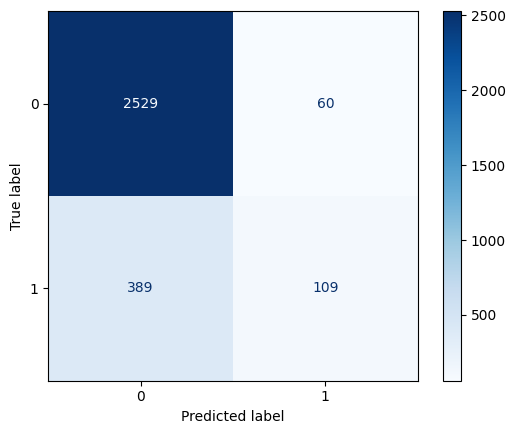

In [134]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Matriz de confusión con labels del pipeline para el training set
cm_train = confusion_matrix(y_train, y_pred_train_base, labels=pipe_base.classes_)

# Mostrar visualmente para el training set
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=pipe_base.classes_)
disp_train.plot(cmap="Blues")  # color opcional
print("\nMatriz de confusión (Train Set):\n", cm_train)

### **Test**

Matriz de confusión (Modelo Base - Test Set):
 [[1081   29]
 [ 166   47]]


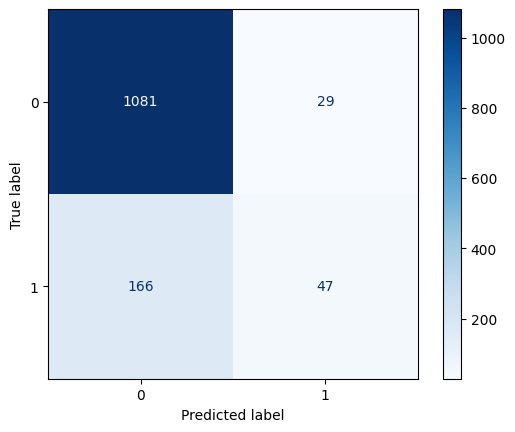

In [135]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Matriz de confusión con labels del pipeline del modelo base
cm_base = confusion_matrix(y_test, y_pred_test_base, labels=pipe_base.classes_)

# Mostrar visualmente
disp_base = ConfusionMatrixDisplay(confusion_matrix=cm_base, display_labels=pipe_base.classes_)
disp_base.plot(cmap="Blues")
print("Matriz de confusión (Modelo Base - Test Set):\n", cm_base)

### **Comparación**

In [136]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# --- Métricas del conjunto de entrenamiento ---
cm_train_base = confusion_matrix(y_train, y_pred_train_base, labels=pipe_base.classes_)

TP_train = cm_train_base[1,1]
FP_train = cm_train_base[0,1]
FN_train = cm_train_base[1,0]
TN_train = cm_train_base[0,0]

print("\n--- Métricas Modelo Base (Train Set) ---")
print(f"Accuracy train: {accuracy_score(y_train, y_pred_train_base):.3f}")
print(f"Precisión (confiabilidad al predecir renuncias): {TP_train/(TP_train+FP_train):.3f}")
print(f"Recall / Sensibilidad (detección de renuncias): {TP_train/(TP_train+FN_train):.3f}")
print(f"F1-score (balance precisión/recall): {f1_score(y_train, y_pred_train_base, average='binary'):.3f}")
print(f"Especificidad (detección de permanencias): {TN_train/(FP_train+TN_train):.3f}\n")

print("*"*100)

# --- Métricas del conjunto de prueba ---
cm_test_base = confusion_matrix(y_test, y_pred_test_base, labels=pipe_base.classes_)

TP_test = cm_test_base[1,1]
FP_test = cm_test_base[0,1]
FN_test = cm_test_base[1,0]
TN_test = cm_test_base[0,0]

print("\n--- Métricas Modelo Base (Test Set) ---")
print(f"Accuracy test: {accuracy_score(y_test, y_pred_test_base):.3f}")
print(f"Precisión (confiabilidad al predecir renuncias): {TP_test/(TP_test+FP_test):.3f}")
print(f"Recall / Sensibilidad (detección de renuncias): {TP_test/(TP_test+FN_test):.3f}")
print(f"F1-score (balance precisión/recall): {f1_score(y_test, y_pred_test_base, average='binary'):.3f}")
print(f"Especificidad (detección de permanencias): {TN_test/(FP_test+TN_test):.3f}")


--- Métricas Modelo Base (Train Set) ---
Accuracy train: 0.855
Precisión (confiabilidad al predecir renuncias): 0.645
Recall / Sensibilidad (detección de renuncias): 0.219
F1-score (balance precisión/recall): 0.327
Especificidad (detección de permanencias): 0.977

****************************************************************************************************

--- Métricas Modelo Base (Test Set) ---
Accuracy test: 0.853
Precisión (confiabilidad al predecir renuncias): 0.618
Recall / Sensibilidad (detección de renuncias): 0.221
F1-score (balance precisión/recall): 0.325
Especificidad (detección de permanencias): 0.974


El Modelo Base tiene una exactitud alta (85%), pero está muy inclinada hacia la clase mayoritaria: quienes se quedan en la empresa. Esto se confirma con su especificidad de casi 98%, lo que significa que predice muy bien a los que permanecen.

El problema está en la detección de renuncias: la sensibilidad apenas llega al 22% y el F1-score ronda el 32%. En la práctica, el modelo deja pasar la gran mayoría de las renuncias reales, aunque cuando predice una sí acierta con cierta confiabilidad (precisión ~62%).

En resumen, el modelo base es útil para identificar estabilidad, pero poco confiable para anticipar salidas. Es consistente entre entrenamiento y prueba, pero no cumple con el objetivo de predecir las renuncias, lo que justifica aplicar técnicas de balanceo.

# <font color='green'> **Balanceo de clases**

## <font color='orange'> **Modelo con `class_weight="balanced"`**

Ajusta de manera automática los pesos de cada clase en la función de optimización, de modo que los errores al clasificar la clase minoritaria (renuncias) tengan un mayor impacto en el entrenamiento. Con este método, el modelo logra equilibrar la importancia de ambas clases sin alterar directamente los datos.

In [137]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

y = df_imputado2["Attrition"].copy()
X_final = df_imputado2.drop(columns=["Attrition"]).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.30, stratify=y, random_state=123)

pipe_ba = Pipeline(steps=[
    ("scaler", StandardScaler()),  # Escalar numéricas
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs"))])

pipe_ba.fit(X_train, y_train)

y_pred_train_ba = pipe_ba.predict(X_train)
y_pred_test_ba  = pipe_ba.predict(X_test)

### **Entrenamiento**

Matriz de confusión (Modelo Balanceado - Train Set):
 [[1866  723]
 [ 126  372]]


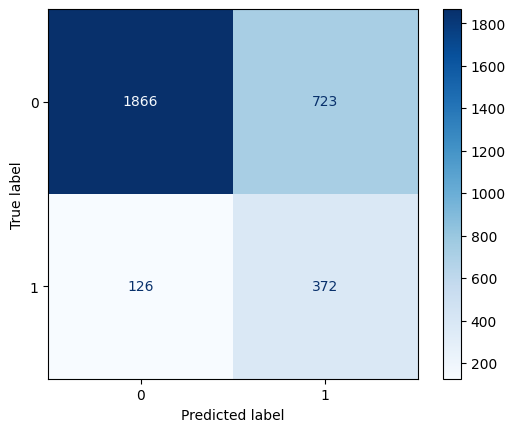

In [138]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Matriz de confusión con labels del pipeline balanceado - TRAIN
cm_train_ba = confusion_matrix(y_train, y_pred_train_ba, labels=pipe_ba.classes_)

# Mostrar visualmente
disp_train_ba = ConfusionMatrixDisplay(confusion_matrix=cm_train_ba, display_labels=pipe_ba.classes_)
disp_train_ba.plot(cmap="Blues")
print("Matriz de confusión (Modelo Balanceado - Train Set):\n", cm_train_ba)

### **Test**

Matriz de confusión (Modelo Balanceado - Test Set):
 [[817 293]
 [ 56 157]]


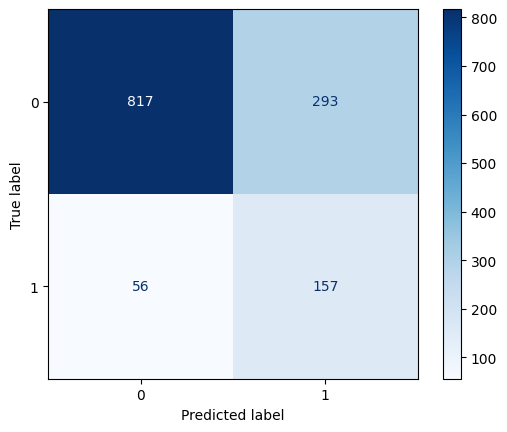

In [139]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Matriz de confusión con labels del pipeline balanceado
cm_ba = confusion_matrix(y_test, y_pred_test_ba, labels=pipe_ba.classes_)

# Mostrar visualmente
disp_ba = ConfusionMatrixDisplay(confusion_matrix=cm_ba, display_labels=pipe_ba.classes_)
disp_ba.plot(cmap="Blues")
print("Matriz de confusión (Modelo Balanceado - Test Set):\n", cm_ba)

### **Comparación**

In [140]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# --- Métricas del conjunto de entrenamiento ---
cm_train_ba = confusion_matrix(y_train, y_pred_train_ba, labels=pipe_ba.classes_)

TP_train_ba = cm_train_ba[1,1]
FP_train_ba = cm_train_ba[0,1]
FN_train_ba = cm_train_ba[1,0]
TN_train_ba = cm_train_ba[0,0]

print("\n--- Métricas Modelo Balanceado (Train Set) ---")
print(f"Accuracy train: {accuracy_score(y_train, y_pred_train_ba):.3f}")
print(f"Precisión (confiabilidad al predecir renuncias): {TP_train_ba/(TP_train_ba+FP_train_ba):.3f}")
print(f"Recall / Sensibilidad (detección de renuncias): {TP_train_ba/(TP_train_ba+FN_train_ba):.3f}")
print(f"F1-score (balance precisión/recall): {f1_score(y_train, y_pred_train_ba, average='binary'):.3f}")
print(f"Especificidad (detección de permanencias): {TN_train_ba/(FP_train_ba+TN_train_ba):.3f}\n")

print("*"*100)

# --- Métricas del conjunto de prueba ---
cm_test_ba = confusion_matrix(y_test, y_pred_test_ba, labels=pipe_ba.classes_)

TP_test_ba = cm_test_ba[1,1]
FP_test_ba = cm_test_ba[0,1]
FN_test_ba = cm_test_ba[1,0]
TN_test_ba = cm_test_ba[0,0]

print("\n--- Métricas Modelo Balanceado (Test Set) ---")
print(f"Accuracy test: {accuracy_score(y_test, y_pred_test_ba):.3f}")
print(f"Precisión (confiabilidad al predecir renuncias): {TP_test_ba/(TP_test_ba+FP_test_ba):.3f}")
print(f"Recall / Sensibilidad (detección de renuncias): {TP_test_ba/(TP_test_ba+FN_test_ba):.3f}")
print(f"F1-score (balance precisión/recall): {f1_score(y_test, y_pred_test_ba, average='binary'):.3f}")
print(f"Especificidad (detección de permanencias): {TN_test_ba/(FP_test_ba+TN_test_ba):.3f}")


--- Métricas Modelo Balanceado (Train Set) ---
Accuracy train: 0.725
Precisión (confiabilidad al predecir renuncias): 0.340
Recall / Sensibilidad (detección de renuncias): 0.747
F1-score (balance precisión/recall): 0.467
Especificidad (detección de permanencias): 0.721

****************************************************************************************************

--- Métricas Modelo Balanceado (Test Set) ---
Accuracy test: 0.736
Precisión (confiabilidad al predecir renuncias): 0.349
Recall / Sensibilidad (detección de renuncias): 0.737
F1-score (balance precisión/recall): 0.474
Especificidad (detección de permanencias): 0.736


El Modelo Balanceado baja la exactitud global (73%), pero logra un comportamiento mucho más equilibrado entre las dos clases. Ya no se concentra tanto en los que se quedan, sino que empieza a detectar de manera real las renuncias.

La sensibilidad sube fuertemente hasta el 74%, lo que significa que ahora identifica la mayoría de las salidas. Sin embargo, la precisión en esas predicciones es baja (34%), lo que indica que también comete bastantes falsos positivos. El F1-score (47%) muestra que este modelo logra un balance mucho mejor que el base.

En conclusión, aunque pierde exactitud y confiabilidad al predecir una renuncia específica, este modelo es mucho más útil para anticipar riesgos de salida. Funciona de forma consistente en entrenamiento y prueba, lo que lo hace estable.

## <font color='orange'> **Modelo con Smote–Tomek**

Combina dos estrategias. Primero, SMOTE genera ejemplos sintéticos de la clase minoritaria, creando nuevos casos de renuncias en lugar de solo duplicarlos. Luego, Tomek Links elimina observaciones de ambas clases que están muy próximas entre sí y generan ambigüedad, con el fin de limpiar el límite de decisión del modelo. Esto permite un balance más representativo y menos ruidoso.

In [141]:
from imblearn.combine import SMOTETomek
from collections import Counter

# 1. Aplicar SMOTE–Tomek (resampling combinado) solo sobre los datos de entrenamiento
os_us_to = SMOTETomek(random_state=123)
X_train_res_to, y_train_res_to = os_us_to.fit_resample(X_train, y_train)

print("Distribución antes del resampling:", Counter(y_train))
print("Distribución después del resampling:", Counter(y_train_res_to))

# 2. Entrenar modelo logístico sobre los datos balanceados
model_smote_tomek_to = LogisticRegression(max_iter=2000, solver="lbfgs", random_state=123)
model_smote_tomek_to.fit(X_train_res_to, y_train_res_to)

# 3. Predicciones sobre el conjunto de prueba original (X_test, y_test)
y_pred_test_to = model_smote_tomek_to.predict(X_test)

Distribución antes del resampling: Counter({0: 2589, 1: 498})
Distribución después del resampling: Counter({0: 2559, 1: 2559})


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



### **Entrenamiento**

Matriz de confusión (Modelo SMOTE–Tomek - Train Set):
 [[2183  376]
 [ 501 2058]]


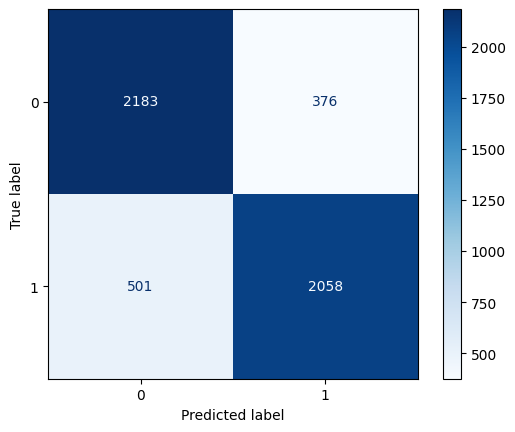

In [142]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Predicciones en el conjunto de entrenamiento
y_pred_train_to = model_smote_tomek_to.predict(X_train_res_to)

# 2. Matriz de confusión con labels del modelo SMOTE–Tomek (train set)
cm_train_to = confusion_matrix(y_train_res_to, y_pred_train_to, labels=model_smote_tomek_to.classes_)

# 3. Mostrar visualmente
disp_train_to = ConfusionMatrixDisplay(confusion_matrix=cm_train_to,
                                       display_labels=model_smote_tomek_to.classes_)
disp_train_to.plot(cmap="Blues")
print("Matriz de confusión (Modelo SMOTE–Tomek - Train Set):\n", cm_train_to)

### **Test**

Matriz de confusión (Modelo SMOTE–Tomek - Test Set):
 [[968 142]
 [106 107]]


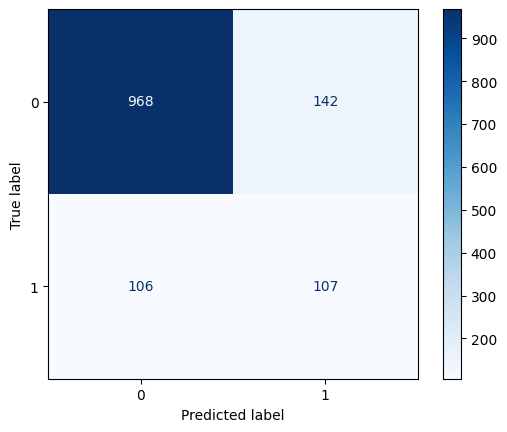

In [143]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Matriz de confusión (Modelo SMOTE–Tomek - Test Set)
cm_test_to = confusion_matrix(y_test, y_pred_test_to, labels=model_smote_tomek_to.classes_)

# 2. Mostrar visualmente
disp_test_to = ConfusionMatrixDisplay(confusion_matrix=cm_test_to,
                                      display_labels=model_smote_tomek_to.classes_)
disp_test_to.plot(cmap="Blues")
print("Matriz de confusión (Modelo SMOTE–Tomek - Test Set):\n", cm_test_to)

### **Comparación**

In [144]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# --- Métricas del conjunto de entrenamiento ---
cm_train_to = confusion_matrix(y_train_res_to, y_pred_train_to, labels=model_smote_tomek_to.classes_)

TP_train = cm_train_to[1,1]
FP_train = cm_train_to[0,1]
FN_train = cm_train_to[1,0]
TN_train = cm_train_to[0,0]

print("\n--- Métricas Modelo SMOTE–Tomek (Train Set) ---")
print(f"Accuracy train: {accuracy_score(y_train_res_to, y_pred_train_to):.3f}")
print(f"Precisión (confiabilidad al predecir renuncias): {TP_train/(TP_train+FP_train):.3f}")
print(f"Recall / Sensibilidad (detección de renuncias): {TP_train/(TP_train+FN_train):.3f}")
print(f"F1-score (balance precisión/recall): {f1_score(y_train_res_to, y_pred_train_to, average='binary'):.3f}")
print(f"Especificidad (detección de permanencias): {TN_train/(FP_train+TN_train):.3f}\n")

print("*"*100)

# --- Métricas del conjunto de prueba ---
cm_test_to = confusion_matrix(y_test, y_pred_test_to, labels=model_smote_tomek_to.classes_)

TP_test = cm_test_to[1,1]
FP_test = cm_test_to[0,1]
FN_test = cm_test_to[1,0]
TN_test = cm_test_to[0,0]

print("\n--- Métricas Modelo SMOTE–Tomek (Test Set) ---")
print(f"Accuracy test: {accuracy_score(y_test, y_pred_test_to):.3f}")
print(f"Precisión (confiabilidad al predecir renuncias): {TP_test/(TP_test+FP_test):.3f}")
print(f"Recall / Sensibilidad (detección de renuncias): {TP_test/(TP_test+FN_test):.3f}")
print(f"F1-score (balance precisión/recall): {f1_score(y_test, y_pred_test_to, average='binary'):.3f}")
print(f"Especificidad (detección de permanencias): {TN_test/(FP_test+TN_test):.3f}")


--- Métricas Modelo SMOTE–Tomek (Train Set) ---
Accuracy train: 0.829
Precisión (confiabilidad al predecir renuncias): 0.846
Recall / Sensibilidad (detección de renuncias): 0.804
F1-score (balance precisión/recall): 0.824
Especificidad (detección de permanencias): 0.853

****************************************************************************************************

--- Métricas Modelo SMOTE–Tomek (Test Set) ---
Accuracy test: 0.813
Precisión (confiabilidad al predecir renuncias): 0.430
Recall / Sensibilidad (detección de renuncias): 0.502
F1-score (balance precisión/recall): 0.463
Especificidad (detección de permanencias): 0.872


El Modelo SMOTE–Tomek muestra un desempeño sobresaliente en entrenamiento, con alta precisión (85%), buen recall (80%) y un F1 equilibrado (82%). Esto indica que en esa etapa logra identificar tanto renuncias como permanencias con bastante exactitud.

Sin embargo, en la prueba los resultados bajan de forma notable. La precisión cae a 43% y el recall a 50%, lo que significa que falla bastante al predecir correctamente las renuncias, aunque mantiene una exactitud global del 81% y una alta capacidad para identificar permanencias (87%).

En conclusión, este modelo parece ajustarse demasiado a los datos de entrenamiento y pierde efectividad en el mundo real. Aunque es sólido en teoría, en la práctica no logra mantener la misma calidad para detectar salidas, por lo que habría que revisarlo o ajustarlo para evitar este sobreajuste.

## <font color='orange'> **Modelo Oversampling (RandomOverSampler)**

Compensa el desbalance aumentando de forma artificial la cantidad de registros de la clase minoritaria. Para ello, replica aleatoriamente ejemplos de renuncias hasta igualar la proporción con las permanencias. Es un método simple pero efectivo, aunque puede aumentar el riesgo de sobreajuste.

In [145]:
# 1. Oversampling de la clase minoritaria
os_over = RandomOverSampler(random_state=123)
X_train_res_over, y_train_res_over = os_over.fit_resample(X_train, y_train)

print("Distribución antes del resampling:", Counter(y_train))
print("Distribución después del resampling:", Counter(y_train_res_over))

Distribución antes del resampling: Counter({0: 2589, 1: 498})
Distribución después del resampling: Counter({0: 2589, 1: 2589})


In [146]:
# 2. Entrenar modelo en los datos balanceados con Oversampling
model_over = LogisticRegression(max_iter=2000, random_state=123)
model_over.fit(X_train_res_over, y_train_res_over)

# 3. Predicciones en el conjunto de prueba original
y_pred_test_over = model_over.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



### **Entrenamiento**

Matriz de confusión (Modelo Oversampling - Train Set):
 [[1889  700]
 [ 644 1945]]


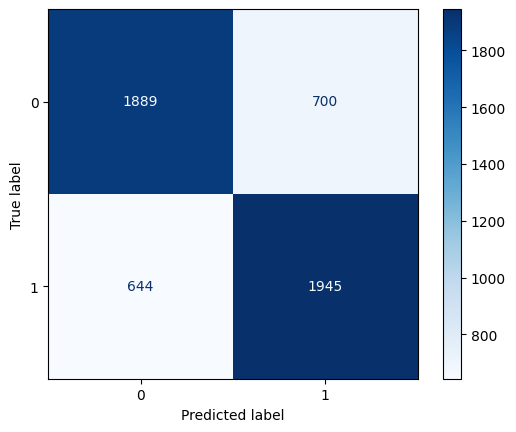

In [147]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Predicciones en el conjunto de entrenamiento (Oversampling)
y_pred_train_over = model_over.predict(X_train_res_over)

# 2. Matriz de confusión con labels del modelo Oversampling (train set)
cm_train_over = confusion_matrix(y_train_res_over, y_pred_train_over, labels=model_over.classes_)

# 3. Mostrar visualmente
disp_train_over = ConfusionMatrixDisplay(confusion_matrix=cm_train_over,
                                         display_labels=model_over.classes_)
disp_train_over.plot(cmap="Blues")
print("Matriz de confusión (Modelo Oversampling - Train Set):\n", cm_train_over)

Vemos en la matriz de confusión que el número de verdaderos negativos es considerable, y esto se puede interpretar debido a que nuestra variable objetivo esta desbalanceada, vamos a usar las metricas a ver si el modelo presenta subajuste o sobre ajuste, de lo contrario se tienda a balancear las clases.

### **Test**

Matriz de confusión (Modelo Oversampling - Test Set):
 [[812 298]
 [ 57 156]]


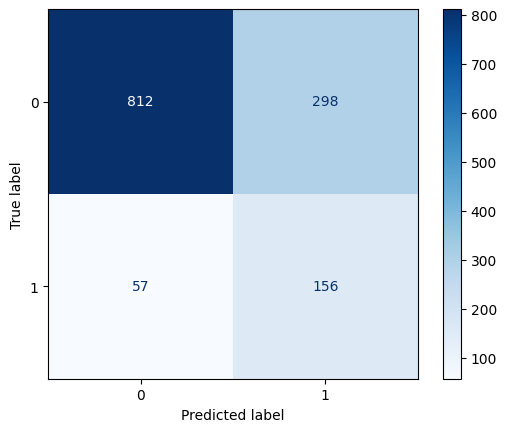

In [148]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Matriz de confusión (Modelo Oversampling - Test Set)
cm_test_over = confusion_matrix(y_test, y_pred_test_over, labels=model_over.classes_)

# 2. Mostrar visualmente
disp_test_over = ConfusionMatrixDisplay(confusion_matrix=cm_test_over,
                                        display_labels=model_over.classes_)
disp_test_over.plot(cmap="Blues")
print("Matriz de confusión (Modelo Oversampling - Test Set):\n", cm_test_over)

### **Comparación**

In [149]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# --- Métricas del conjunto de entrenamiento ---
cm_train_over = confusion_matrix(y_train_res_over, y_pred_train_over, labels=model_over.classes_)

TP_train = cm_train_over[1,1]
FP_train = cm_train_over[0,1]
FN_train = cm_train_over[1,0]
TN_train = cm_train_over[0,0]

print("\n--- Métricas Modelo Oversampling (Train Set) ---")
print(f"Accuracy train: {accuracy_score(y_train_res_over, y_pred_train_over):.3f}")
print(f"Precisión (confiabilidad al predecir renuncias): {TP_train/(TP_train+FP_train):.3f}")
print(f"Recall / Sensibilidad (detección de renuncias): {TP_train/(TP_train+FN_train):.3f}")
print(f"F1-score (balance precisión/recall): {f1_score(y_train_res_over, y_pred_train_over, average='binary'):.3f}")
print(f"Especificidad (detección de permanencias): {TN_train/(FP_train+TN_train):.3f}\n")

print("*"*100)

# --- Métricas del conjunto de prueba ---
cm_test_over = confusion_matrix(y_test, y_pred_test_over, labels=model_over.classes_)

TP_test = cm_test_over[1,1]
FP_test = cm_test_over[0,1]
FN_test = cm_test_over[1,0]
TN_test = cm_test_over[0,0]

print("\n--- Métricas Modelo Oversampling (Test Set) ---")
print(f"Accuracy test: {accuracy_score(y_test, y_pred_test_over):.3f}")
print(f"Precisión (confiabilidad al predecir renuncias): {TP_test/(TP_test+FP_test):.3f}")
print(f"Recall / Sensibilidad (detección de renuncias): {TP_test/(TP_test+FN_test):.3f}")
print(f"F1-score (balance precisión/recall): {f1_score(y_test, y_pred_test_over, average='binary'):.3f}")
print(f"Especificidad (detección de permanencias): {TN_test/(FP_test+TN_test):.3f}")


--- Métricas Modelo Oversampling (Train Set) ---
Accuracy train: 0.740
Precisión (confiabilidad al predecir renuncias): 0.735
Recall / Sensibilidad (detección de renuncias): 0.751
F1-score (balance precisión/recall): 0.743
Especificidad (detección de permanencias): 0.730

****************************************************************************************************

--- Métricas Modelo Oversampling (Test Set) ---
Accuracy test: 0.732
Precisión (confiabilidad al predecir renuncias): 0.344
Recall / Sensibilidad (detección de renuncias): 0.732
F1-score (balance precisión/recall): 0.468
Especificidad (detección de permanencias): 0.732


El Modelo Oversampling tiene un rendimiento muy equilibrado en el entrenamiento: precisión y recall rondan el 74–75%, con un F1 consistente (74%). Esto significa que, dentro de esos datos, logra identificar bien tanto a quienes renuncian como a quienes permanecen.

En el conjunto de prueba, el modelo mantiene una buena capacidad de detección de renuncias (73% de recall), pero su precisión baja mucho (34%), lo que indica que genera bastantes “falsas alarmas”. Aun así, la exactitud global (73%) y la especificidad (73%) se sostienen.

En resumen, este modelo es consistente y estable, pero sacrifica precisión al detectar renuncias. Funciona bien para no dejar pasar casos de salida, aunque a costa de predecir algunas renuncias que en realidad no ocurren.

## <font color='orange'> **Modelo con Subsampling con NearMiss**

Reduce el tamaño de la clase mayoritaria eliminando registros de permanencias, hasta equilibrar la proporción con las renuncias. Aunque mejora la capacidad de detección de la clase minoritaria, este método implica pérdida de información valiosa de la clase mayoritaria, lo que puede afectar la capacidad de generalización del modelo.

In [150]:
# 1. Subsampling con NearMiss (reduce la clase mayoritaria)
us_sub = NearMiss()
X_train_res_sub, y_train_res_sub = us_sub.fit_resample(X_train, y_train)

print("Distribución antes del resampling:", Counter(y_train))
print("Distribución después del resampling:", Counter(y_train_res_sub))

Distribución antes del resampling: Counter({0: 2589, 1: 498})
Distribución después del resampling: Counter({0: 498, 1: 498})


In [151]:
# 2. Entrenar modelo en datos balanceados por undersampling
model_sub = LogisticRegression(max_iter=2000, random_state=123)
model_sub.fit(X_train_res_sub, y_train_res_sub)

# 3. Predicciones en el conjunto de prueba original
y_pred_test_sub = model_sub.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



### **Entrenamiento**

Matriz de confusión (Modelo Undersampling - Train Set):
 [[387 111]
 [109 389]]


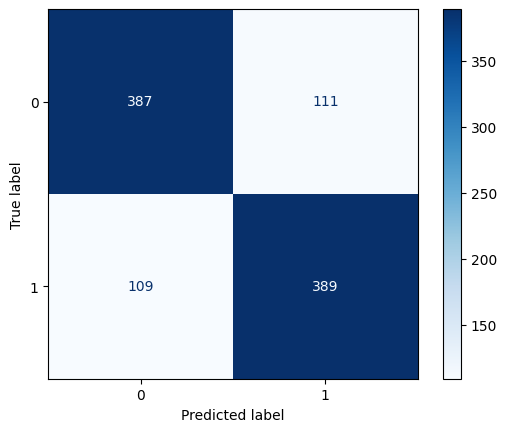

In [152]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Predicciones en el conjunto de entrenamiento (Undersampling)
y_pred_train_sub = model_sub.predict(X_train_res_sub)

# 2. Matriz de confusión con labels del modelo Undersampling (train set)
cm_train_sub = confusion_matrix(y_train_res_sub, y_pred_train_sub, labels=model_sub.classes_)

# 3. Mostrar visualmente
disp_train_sub = ConfusionMatrixDisplay(confusion_matrix=cm_train_sub,
                                        display_labels=model_sub.classes_)
disp_train_sub.plot(cmap="Blues")
print("Matriz de confusión (Modelo Undersampling - Train Set):\n", cm_train_sub)

### **Test**

Matriz de confusión (Modelo Undersampling - Test Set):
 [[690 420]
 [ 63 150]]


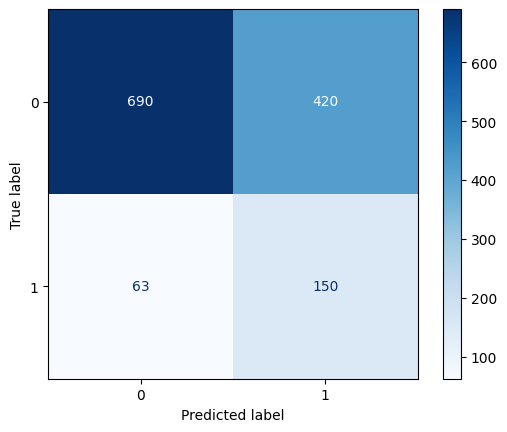

In [153]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Matriz de confusión (Modelo Undersampling - Test Set)
cm_test_sub = confusion_matrix(y_test, y_pred_test_sub, labels=model_sub.classes_)

# 2. Mostrar visualmente
disp_test_sub = ConfusionMatrixDisplay(confusion_matrix=cm_test_sub,
                                       display_labels=model_sub.classes_)
disp_test_sub.plot(cmap="Blues")
print("Matriz de confusión (Modelo Undersampling - Test Set):\n", cm_test_sub)

### **Comparación**

In [154]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# --- Métricas del conjunto de entrenamiento ---
cm_train_sub = confusion_matrix(y_train_res_sub, y_pred_train_sub, labels=model_sub.classes_)

TP_train = cm_train_sub[1,1]
FP_train = cm_train_sub[0,1]
FN_train = cm_train_sub[1,0]
TN_train = cm_train_sub[0,0]

print("\n--- Métricas Modelo Undersampling (Train Set) ---")
print(f"Accuracy train: {accuracy_score(y_train_res_sub, y_pred_train_sub):.3f}")
print(f"Precisión (confiabilidad al predecir renuncias): {TP_train/(TP_train+FP_train):.3f}")
print(f"Recall / Sensibilidad (detección de renuncias): {TP_train/(TP_train+FN_train):.3f}")
print(f"F1-score (balance precisión/recall): {f1_score(y_train_res_sub, y_pred_train_sub, average='binary'):.3f}")
print(f"Especificidad (detección de permanencias): {TN_train/(FP_train+TN_train):.3f}\n")

print("*"*100)

# --- Métricas del conjunto de prueba ---
cm_test_sub = confusion_matrix(y_test, y_pred_test_sub, labels=model_sub.classes_)

TP_test = cm_test_sub[1,1]
FP_test = cm_test_sub[0,1]
FN_test = cm_test_sub[1,0]
TN_test = cm_test_sub[0,0]

print("\n--- Métricas Modelo Undersampling (Test Set) ---")
print(f"Accuracy test: {accuracy_score(y_test, y_pred_test_sub):.3f}")
print(f"Precisión (confiabilidad al predecir renuncias): {TP_test/(TP_test+FP_test):.3f}")
print(f"Recall / Sensibilidad (detección de renuncias): {TP_test/(TP_test+FN_test):.3f}")
print(f"F1-score (balance precisión/recall): {f1_score(y_test, y_pred_test_sub, average='binary'):.3f}")
print(f"Especificidad (detección de permanencias): {TN_test/(FP_test+TN_test):.3f}")


--- Métricas Modelo Undersampling (Train Set) ---
Accuracy train: 0.779
Precisión (confiabilidad al predecir renuncias): 0.778
Recall / Sensibilidad (detección de renuncias): 0.781
F1-score (balance precisión/recall): 0.780
Especificidad (detección de permanencias): 0.777

****************************************************************************************************

--- Métricas Modelo Undersampling (Test Set) ---
Accuracy test: 0.635
Precisión (confiabilidad al predecir renuncias): 0.263
Recall / Sensibilidad (detección de renuncias): 0.704
F1-score (balance precisión/recall): 0.383
Especificidad (detección de permanencias): 0.622


El Modelo Undersampling se desempeña muy bien en el entrenamiento, con métricas equilibradas y cercanas al 78% en todas las dimensiones (precisión, recall, especificidad y F1). Esto refleja que, dentro de esos datos, el modelo es sólido y balanceado en la detección de renuncias y permanencias.

Sin embargo, al probarlo con datos nuevos, su rendimiento cae de forma importante: la exactitud baja al 63%, la precisión al 26% y el F1 al 38%. Aunque mantiene un recall relativamente alto (70%), la cantidad de falsos positivos es considerable, lo que indica que el modelo predice muchas renuncias que en realidad no ocurren.

En resumen, el undersampling genera un modelo muy balanceado en el entrenamiento, pero con poca capacidad de generalización. Es útil para captar renuncias, aunque su baja precisión lo hace poco confiable en escenarios reales.

# **Análisis**

El modelo base resulta útil únicamente para detectar permanencias, ya que identifica pocas renuncias. En contraste, los modelos balanceado y oversampling son más efectivos cuando el objetivo es anticipar salidas, pues logran una alta sensibilidad aunque sacrifican precisión. El SMOTE–Tomek se comporta muy bien en el entrenamiento, pero pierde consistencia al aplicarse a nuevos datos, lo que lo hace menos confiable en la práctica. Finalmente, el undersampling no es recomendable, ya que muestra una fuerte pérdida de generalización y predice demasiadas falsas salidas.

Podemos complementar este análisis con los resultados de la curva ROC y el AUC, lo que nos permitirá comparar de forma más clara la capacidad de discriminación de cada modelo entre quienes renuncian y quienes permanecen, evaluando no solo métricas puntuales, sino también su rendimiento global.

# <font color='Blue'> **Comparacion con la curva ROC**

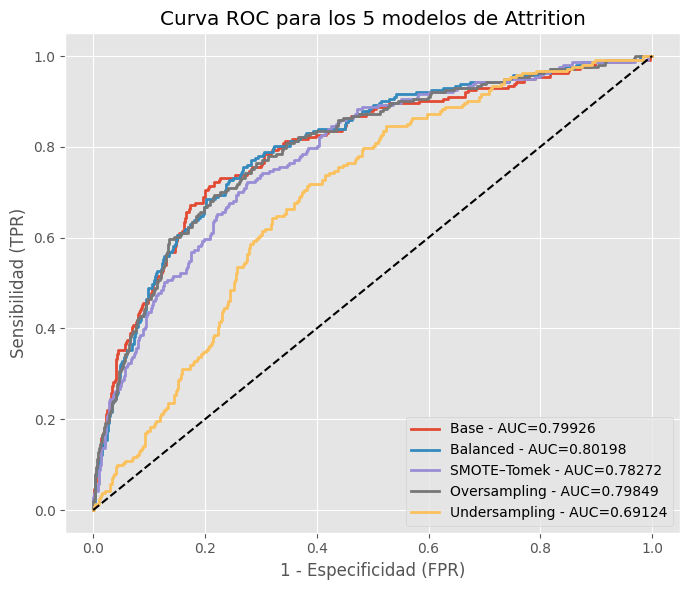

In [155]:
try:
    model_base
except NameError:
    model_base = pipe_base          # Modelo Base (sin balanceo)

try:
    model_ba
except NameError:
    model_ba = pipe_ba              # Modelo con class_weight="balanced"

try:
    model_to
except NameError:
    model_to = model_smote_tomek_to # SMOTE–Tomek

try:
    model_over
except NameError:
    model_over = model_ros          # Oversampling (ROS)

try:
    model_sub
except NameError:
    model_sub = model_sub           # Undersampling (NearMiss)


# ====== Curvas ROC ======
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

plt.style.use('ggplot')
plt.figure(figsize=(7,6)).clf()

# Modelo 1 - Base
y_pred_base = model_base.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_base)
auc = roc_auc_score(y_test, y_pred_base)
plt.plot(fpr, tpr, lw=2, label="Base - AUC=" + str(round(auc,5)))

# Modelo 2 - Balanced (class_weight="balanced")
y_pred_ba = model_ba.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_ba)
auc = roc_auc_score(y_test, y_pred_ba)
plt.plot(fpr, tpr, lw=2, label="Balanced - AUC=" + str(round(auc,5)))

# Modelo 3 - SMOTE–Tomek
y_pred_to = model_to.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_to)
auc = roc_auc_score(y_test, y_pred_to)
plt.plot(fpr, tpr, lw=2, label="SMOTE–Tomek - AUC=" + str(round(auc,5)))

# Modelo 4 - Oversampling
y_pred_over = model_over.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_over)
auc = roc_auc_score(y_test, y_pred_over)
plt.plot(fpr, tpr, lw=2, label="Oversampling - AUC=" + str(round(auc,5)))

# Modelo 5 - Undersampling
y_pred_sub = model_sub.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_sub)
auc = roc_auc_score(y_test, y_pred_sub)
plt.plot(fpr, tpr, lw=2, label="Undersampling - AUC=" + str(round(auc,5)))

# Línea de referencia
plt.plot([0, 1], [0, 1], 'k--')

plt.title('Curva ROC para los 5 modelos de Attrition')
plt.xlabel('1 - Especificidad (FPR)')
plt.ylabel('Sensibilidad (TPR)')
plt.legend(loc=4, frameon=True)
plt.tight_layout()
plt.show()

Al complementar los resultados con la curva ROC y los valores de AUC, se confirma que el modelo balanceado con **class_weight=balanced** es el más sólido en términos generales. Este no solo logra un AUC ligeramente superior al resto **(≈ 0.802)**, sino que también mantiene un buen equilibrio entre recall y especificidad, lo que lo hace confiable para detectar renuncias sin perder demasiada precisión en las permanencias.

Aunque el modelo oversampling y el base tienen desempeños cercanos, el balanceado muestra mayor estabilidad y consistencia, especialmente al manejar datos desbalanceados. En contraste, SMOTE–Tomek pierde fuerza en pruebas y el undersampling sacrifica demasiada información, resultando menos recomendables.

# **Conclusión General**

El modelo evaluado alcanzó un valor de **AUC = 0.802**, lo que refleja una adecuada capacidad discriminativa entre las clases analizadas. Esto significa que el modelo logra distinguir correctamente, en alrededor del 80% de los casos, entre observaciones positivas y negativas seleccionadas al azar. En consecuencia, el desempeño obtenido puede considerarse satisfactorio y confiable, respaldando su utilidad en el análisis realizado.

Además, se observa que el modelo generaliza de manera adecuada sobre los datos, lo que indica que logró aprender patrones relevantes sin caer en sobreajuste.

Finalmente, dado que en este caso lo más importante es detectar la mayor cantidad posible de renuncias (Recall/Sensibilidad), el modelo que mejor se ajusta a nuestro objetivo es el ***modelo balanceado con class_weight=balanced***, ya que ofrece el mejor equilibrio entre la detección de renuncias y la capacidad discriminativa global frente a las demás alternativas.